# Assessing the Difficulty of Trivia Questions

## Objective

Trivia events have become big busines in recent years, with a number of companies providing trivia services locally and nationally. The pandemic initially put a damper on these events, but they were soon adapted to online platforms such as Zoom. Even Netflix has gotten in on the trivia trend, with a daily interactive trivia game being launched on their streaming service in April 2022.

There's an art to crafting a successful trivia event. The questions can't be too easy, or people will become bored. They also can't be too difficult, or people will disengage. There needs to be a mixture of easy, medium, and hard questions in order for participants to experience both successes and stumbles. This can be hard to achieve since the perceived difficulty of questions can be highly subjective.

The objective of this project is to create a model using natural language processing to assess the level of difficulty of trivia questions. This will help ensure that your trivia events hit the sweet spot where players are appropriately challenged, stay engaged, and have a good time.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

In [6]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [7]:
from textblob import TextBlob
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [10]:
from tensorflow.keras.layers import Dropout, Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

## Import Data

In [11]:
df = pd.read_csv("combined_season1-37.tsv.zip", delimiter='\t')

In [7]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,100,no,LAKES & RIVERS,-,River mentioned most often in the Bible,the Jordan,1984-09-10,-
1,1,200,no,LAKES & RIVERS,-,Scottish word for lake,loch,1984-09-10,-
2,1,800,yes,LAKES & RIVERS,-,River in this famous song:,the Volga River,1984-09-10,-
3,1,400,no,LAKES & RIVERS,-,American river only 33 miles shorter than the ...,the Missouri,1984-09-10,-
4,1,500,no,LAKES & RIVERS,-,"World's largest lake, nearly 5 times as big as...",the Caspian Sea,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389440,2,400,no,FOUNDRY,-,This hefty noisemaker from Whitechapel Foundry...,Big Ben,2021-08-13,-
389441,2,800,no,FOUNDRY,-,"Around 4,000 years ago, the first foundries in...",bronze,2021-08-13,-
389442,2,1200,no,FOUNDRY,-,Several different foundries worked for 4 month...,Monitor,2021-08-13,-
389443,2,1600,no,FOUNDRY,-,"Once one of the largest of its kind, the Gary ...",U.S. Steel,2021-08-13,-


## EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389445 entries, 0 to 389444
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   round         389445 non-null  int64 
 1   value         389445 non-null  int64 
 2   daily_double  389445 non-null  object
 3   category      389445 non-null  object
 4   comments      389445 non-null  object
 5   answer        389445 non-null  object
 6   question      389445 non-null  object
 7   air_date      389445 non-null  object
 8   notes         389445 non-null  object
dtypes: int64(2), object(7)
memory usage: 26.7+ MB


In [9]:
df.isna().sum()

round           0
value           0
daily_double    0
category        0
comments        0
answer          0
question        0
air_date        0
notes           0
dtype: int64

In [10]:
df['air_date'].sort_values()

0         1984-09-10
26        1984-09-10
27        1984-09-10
28        1984-09-10
29        1984-09-10
             ...    
389410    2021-08-13
389411    2021-08-13
389412    2021-08-13
389414    2021-08-13
389444    2021-08-13
Name: air_date, Length: 389445, dtype: object

In [11]:
df['category'].nunique()

47752

In [12]:
df['category'].value_counts().loc[lambda x : x>500] 

SCIENCE                    966
AMERICAN HISTORY           897
LITERATURE                 858
POTPOURRI                  790
HISTORY                    786
WORD ORIGINS               713
BEFORE & AFTER             710
SPORTS                     705
WORLD HISTORY              671
WORLD GEOGRAPHY            657
BUSINESS & INDUSTRY        607
TRANSPORTATION             607
U.S. CITIES                603
RELIGION                   571
COLLEGES & UNIVERSITIES    562
ART                        554
ANIMALS                    544
BODIES OF WATER            535
WORLD CAPITALS             529
U.S. GEOGRAPHY             522
BOOKS & AUTHORS            520
AUTHORS                    514
U.S. HISTORY               512
ISLANDS                    505
Name: category, dtype: int64

In [13]:
df['question'].value_counts().loc[lambda x : x>200] 

Australia       355
Chicago         349
China           343
France          328
Japan           319
India           301
California      301
Spain           298
Canada          284
Alaska          277
Mexico          271
Texas           253
Florida         252
Italy           246
Hawaii          242
Brazil          241
Paris           237
Russia          232
South Africa    230
New York        230
Ireland         223
Germany         221
Egypt           219
Greece          217
Boston          217
New Orleans     214
Sweden          213
London          212
Name: question, dtype: int64

In [14]:
df.groupby('round')['category'].nunique()

round
1    26203
2    24994
3     3082
Name: category, dtype: int64

In [15]:
df.groupby('round')['category'].value_counts()

round  category           
1      SPORTS                 551
       POTPOURRI              497
       AMERICAN HISTORY       409
       ANIMALS                378
       SCIENCE                369
                             ... 
3      \'90s MOVIES             1
       \'90s NONFICTION         1
       \'90s NOTABLES           1
       \'90s OLYMPIC NAMES      1
       \'90s TRENDS             1
Name: category, Length: 54279, dtype: int64

In [16]:
df['value'].value_counts().loc[lambda x : x>90] 

400     75835
800     60242
200     51791
1000    38834
600     36751
2000    26217
1200    23900
1600    22646
100     13116
500     12714
300     12460
0        6647
3000     1684
1500      821
4000      783
5000      511
2500      409
1400      391
1800      331
2200      264
700       259
2400      242
6000      181
2600      175
2800      143
3200      134
900       133
3500      115
1300      107
3400      107
3600      106
Name: value, dtype: int64

## Data Cleaning

In [13]:
# Change 'air_date' into datetime type
df['air_date'] = pd.to_datetime(df['air_date'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389445 entries, 0 to 389444
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   round         389445 non-null  int64         
 1   value         389445 non-null  int64         
 2   daily_double  389445 non-null  object        
 3   category      389445 non-null  object        
 4   comments      389445 non-null  object        
 5   answer        389445 non-null  object        
 6   question      389445 non-null  object        
 7   air_date      389445 non-null  datetime64[ns]
 8   notes         389445 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 26.7+ MB


In [15]:
# On 11/26/2001, the values for the questions doubled for both rounds of Jeopardy. Need to adjust the earlier episodes to have the same values as post-11/26/2001 shows.
df.loc[df['air_date'] < '2001-11-26', "value"] = df.value * 2

In [16]:
# Remove Daily Doubles since the contestants can wager any amounts for those
df = df[df["daily_double"] != 'yes']

In [17]:
#Check remaining value amounts
df['value'].value_counts()

400     76866
800     73024
200     39048
600     37009
1000    35736
1200    34668
2000    34304
1600    33110
0        6647
3200        1
4000        1
2400        1
2547        1
Name: value, dtype: int64

In [18]:
# Keep only standard values (this will remove Final Jeopardy questions, which do not have a set amount and set are at '0', as well as the handful of non-standard values that are likely typos)
df = df.loc[df['value'].isin([200, 400, 600, 800, 1000, 400, 800, 1200, 1600, 2000])]

## NLP Data Cleaning

In [22]:
# Import string to remove punctuation

import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
# Create function to remove punctuation

def no_punctuation(text):
    nopunct=[words for words in text if words not in string.punctuation]
    words_without_punct=''.join(nopunct)
    return words_without_punct

In [24]:
# Remove punctuation and lowercase words in 'category,' 'answer,' and 'question'

df['category'] = df['category'].apply(lambda x: no_punctuation(x).lower())
df['answer'] = df['answer'].apply(lambda x: no_punctuation(x).lower())
df['question'] = df['question'].apply(lambda x: no_punctuation(x).lower())

In [25]:
# Remove numerals from 'category,' 'answer,' and 'question'

df['category'] = df['category'].str.replace('\d+', '')
df['answer'] = df['answer'].str.replace('\d+', '')
df['question'] = df['question'].str.replace('\d+', '')

In [26]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-


In [27]:
# Create a new column that contains questions and answers
df["q_and_a"] = df["answer"] + ' ' + df["question"]

In [28]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes,q_and_a
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-,river mentioned most often in the bible the jo...
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-,scottish word for lake loch
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-,american river only miles shorter than the mi...
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-,worlds largest lake nearly times as big as su...
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-,marconis wonderful wireless the radio
...,...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-,in a moveable feast gertrude stein is quoted a...
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-,this hefty noisemaker from whitechapel foundry...
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-,around years ago the first foundries in mesop...
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-,several different foundries worked for months...


In [29]:
# Tokenize words in "q_and_a" column
df['q_and_a'] = df['q_and_a'].apply(word_tokenize)

# Lemmatize "q_and_a" column
lemmatizer = WordNetLemmatizer()
df['q_and_a'] = df['q_and_a'].apply(lambda row:[lemmatizer.lemmatize(word) for word in row])

In [30]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes,q_and_a
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-,"[river, mentioned, most, often, in, the, bible..."
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-,"[scottish, word, for, lake, loch]"
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-,"[american, river, only, mile, shorter, than, t..."
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-,"[world, largest, lake, nearly, time, a, big, a..."
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-,"[marconi, wonderful, wireless, the, radio]"
...,...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-,"[in, a, moveable, feast, gertrude, stein, is, ..."
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-,"[this, hefty, noisemaker, from, whitechapel, f..."
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-,"[around, year, ago, the, first, foundry, in, m..."
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-,"[several, different, foundry, worked, for, mon..."


In [32]:
# Change the "q_and_a" so it's not a list of lists
df['q_and_a'] = df['q_and_a'].str.join(" ")
df

,round,value,daily_double,category,comments,answer,question,air_date,notes,q_and_a
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-,r i v e r m e n t i o n e d m o s t o f ...
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-,s c o t t i s h w o r d f o r l a k e ...
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-,a m e r i c a n r i v e r o n l y m i l ...
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-,w o r l d l a r g e s t l a k e n e a r ...
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-,m a r c o n i w o n d e r f u l w i r e l ...
...,...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-,i n a m o v e a b l e f e a s t g e r ...
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-,t h i s h e f t y n o i s e m a k e r f ...
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-,a r o u n d y e a r a g o t h e f i r ...
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-,s e v e r a l d i f f e r e n t f o u n d ...


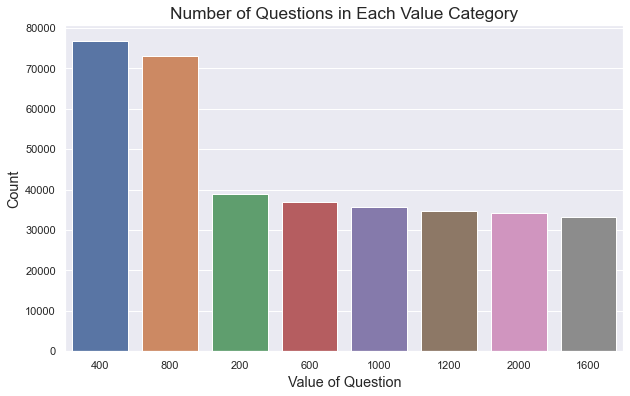

In [26]:
# Visualize the counts of each value category
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=df, 
    x="value",
    order=df.value.value_counts().index)

ax.set_title('Number of Questions in Each Value Category',fontsize='x-large')
ax.set_xlabel('Value of Question',fontsize='large')
ax.set_ylabel('Count',fontsize='large')

plt.show();

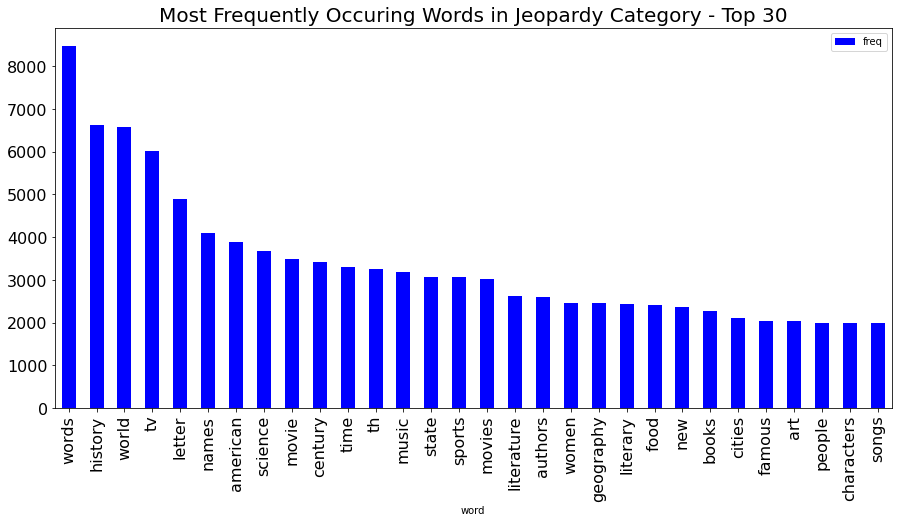

In [34]:
# Graph the frequency of the top 30 words in 'category'

cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.category)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title('Most Frequently Occuring Words in Jeopardy Category - Top 30', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

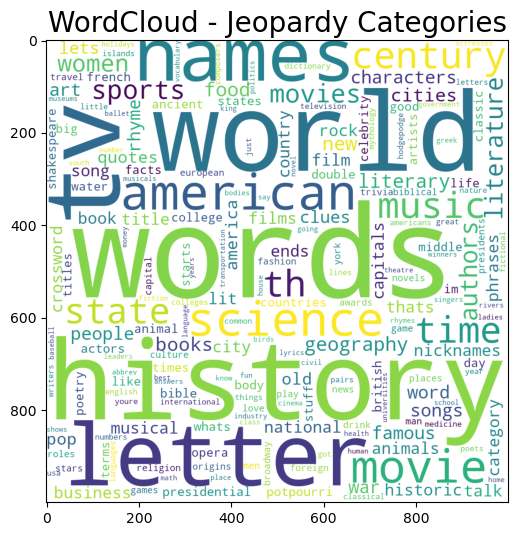

In [38]:
# Create word cloud of Jeopardy categories

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
sns.reset_defaults() 
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.title('WordCloud - Jeopardy Categories', fontsize = 20);

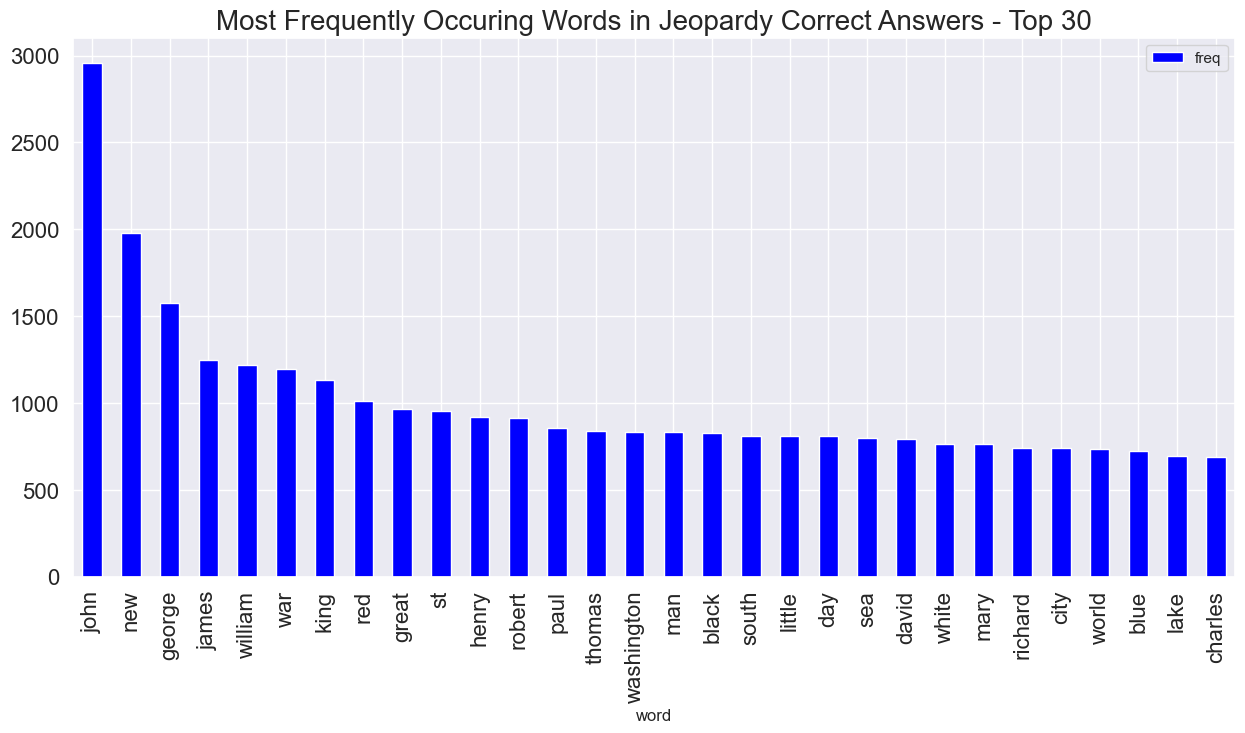

In [39]:
# Graph the frequency of the top 30 words in 'question' (the correct answers)

cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.question)
sns.set_theme(style="darkgrid")
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title('Most Frequently Occuring Words in Jeopardy Correct Answers - Top 30', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

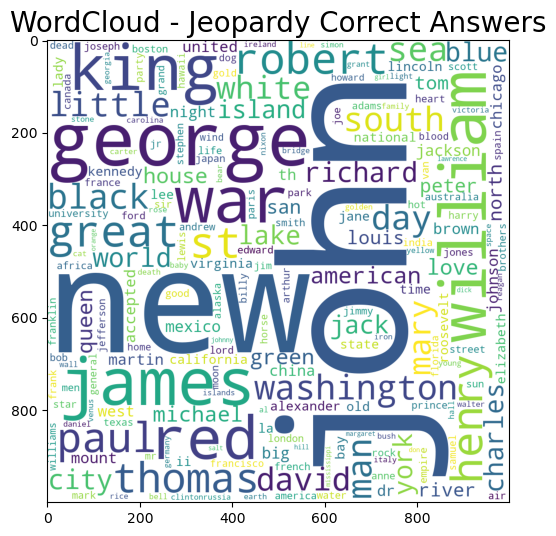

In [40]:
# Create a word cloud of Jeopardy correct answers

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
sns.reset_defaults() 
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.title('WordCloud - Jeopardy Correct Answers', fontsize = 20)
plt.savefig('answer_wordcloud.png');

## Exploring Tf-idf Vectorizer Settings

In [21]:
# Use 'q_and_a' (Jeopardy questions amd answers combined) as the feature and 'value' as the target
X = df['q_and_a']
y = df['value']

In [22]:
# Create a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=54)

In [23]:
# Find the shape of X_train_vectorized only using stopwords
tfidf = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on X_train and transform it
X_train_vectorized1 = tfidf.fit_transform(X_train)

In [45]:
X_train_vectorized1.shape

(272823, 108982)

In [58]:
# Find the shape of X_train_vectorized using stopwords, bigrams
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 2))

# Fit the vectorizer on X_train and transform it
X_train_vectorized2 = tfidf.fit_transform(X_train)

In [47]:
X_train_vectorized2.shape

(272823, 1493999)

In [123]:
# Find the shape of X_train_vectorized using stopwords, bigrams and trigrams
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3))

# Fit the vectorizer on X_train and transform it
X_train_vectorized3 = tfidf.fit_transform(X_train)

In [124]:
X_train_vectorized3.shape

(272823, 3284454)

In [77]:
# Find the shape of X_train_vectorized using stopwords, bigrams and trigrams, and ignoring one-off tokens
tfidf = TfidfVectorizer(stop_words='english', min_df=2)

# Fit the vectorizer on X_train and transform it
X_train_vectorized4 = tfidf.fit_transform(X_train)

In [78]:
X_train_vectorized4.shape

(272823, 387923)

In [30]:
# Find the shape of X_train_vectorized using stopwords, bigrams and trigrams, ignoring two-off tokens, and limiting features to 100000
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3), max_features=100000)

# Fit the vectorizer on X_train and transform it
X_train_vectorized5 = tfidf.fit_transform(X_train)

In [85]:
X_train_vectorized5.shape

(272823, 100000)

In [31]:
# Find shape of X_train_vectorized using stopwords, bigrams and trigrams, ignoring two-off tokens, and limiting features to 10000
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3), max_features=10000)

# Fit the vectorizer on X_train and transform it
X_train_vectorized6 = tfidf.fit_transform(X_train)

In [87]:
X_train_vectorized6.shape

(272823, 10000)

In [32]:
# Find the shape of X_train_vectorized using stopwords, bigrams and trigrams, ignoring two-off tokens, and limiting features to 5000
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3), max_features=5000)

# Fit the vectorizer on X_train and transform it
X_train_vectorized7 = tfidf.fit_transform(X_train)

In [94]:
X_train_vectorized7.shape

(272823, 5000)

In [71]:
#find shape of X_train_vectorized using stopwords, bigrams and trigrams, ignoring two-off tokens, and limiting features to 1000
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3), max_features=1000)

# Fit the vectorizer on X_train and transform it
X_train_vectorized8 = tfidf.fit_transform(X_train)

In [96]:
X_train_vectorized8.shape

(272823, 1000)

In [104]:
# Find the shape of X_train_vectorized using stopwords, bigrams and trigrams, ignoring two-off tokens,and limiting features to 150000
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3), max_features=150000)

# Fit the vectorizer on X_train and transform it
X_train_vectorized9 = tfidf.fit_transform(X_train)

In [105]:
X_train_vectorized9.shape

(272823, 150000)

## Linear Regression Model

In [26]:
# Calculate mean absolute percentage error (MAPE) as scoring metric for models
# Shout out to Pablo Andrés Castañeda, https://stackoverflow.com/questions/47648133/mape-calculation-in-python/59033147#59033147 

def percentage_error(actual, predicted):
   res = np.empty(actual.shape)
   for j in range(actual.shape[0]):
       if actual[j] != 0:
           res[j] = (actual[j] - predicted[j]) / actual[j]
       else:
           res[j] = predicted[j] / np.mean(actual)
   return res

def mean_absolute_percentage_error(y_test, y_pred): 
   return np.mean(np.abs(percentage_error(np.asarray(y_test), np.asarray(y_pred)))) * 100

mape_score = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [71]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr1 = cross_val_score(baseline_lr, X_train_vectorized1, y_train, cv=2, scoring=mape_score)
baseline_lr1

array([-87.43378716, -87.76278212])

In [72]:
print("Vec1 Score: ", baseline_lr1.mean())

Vec1 Score:  -87.59828464083122


In [69]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr2 = cross_val_score(baseline_lr, X_train_vectorized2, y_train, cv=2, scoring=mape_score)
baseline_lr2

array([-76.37154713, -76.55847814])

In [73]:
print("Vec1 Score: ", baseline_lr1.mean())
print("Vec2 Score: ", baseline_lr2.mean())

Vec1 Score:  -87.59828464083122
Vec2 Score:  -76.46501263651861


In [74]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr3 = cross_val_score(baseline_lr, X_train_vectorized3, y_train, cv=2, scoring=mape_score)
baseline_lr3

array([-75.50346048, -75.81198866])

In [75]:
print("Vec1 Score: ", baseline_lr1.mean())
print("Vec2 Score: ", baseline_lr2.mean())
print("Vec3 Score: ", baseline_lr3.mean())

Vec1 Score:  -87.59828464083122
Vec2 Score:  -76.46501263651861
Vec3 Score:  -75.65772457019136


In [79]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr4 = cross_val_score(baseline_lr, X_train_vectorized4, y_train, cv=2, scoring=mape_score)
baseline_lr4

array([-123.98951878, -114.09273654])

In [80]:
print("Vec1 Score: ", baseline_lr1.mean())
print("Vec2 Score: ", baseline_lr2.mean())
print("Vec3 Score: ", baseline_lr3.mean())
print("Vec4 Score: ", baseline_lr4.mean())

Vec1 Score:  -87.59828464083122
Vec2 Score:  -76.46501263651861
Vec3 Score:  -75.65772457019136
Vec4 Score:  -119.04112766342772


In [88]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr5 = cross_val_score(baseline_lr, X_train_vectorized5, y_train, cv=2, scoring=mape_score)
baseline_lr5

array([-121.97642496, -120.92649685])

In [89]:
print("Vec1 Score: ", baseline_lr1.mean())
print("Vec2 Score: ", baseline_lr2.mean())
print("Vec3 Score: ", baseline_lr3.mean())
print("Vec4 Score: ", baseline_lr4.mean())
print("Vec4 Score: ", baseline_lr5.mean())

Vec1 Score:  -87.59828464083122
Vec2 Score:  -76.46501263651861
Vec3 Score:  -75.65772457019136
Vec4 Score:  -119.04112766342772
Vec4 Score:  -121.4514609060497


In [90]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr6 = cross_val_score(baseline_lr, X_train_vectorized6, y_train, cv=2, scoring=mape_score)
baseline_lr6

array([-77.25868187, -77.75466171])

In [91]:
print("Vec1 Score: ", baseline_lr1.mean())
print("Vec2 Score: ", baseline_lr2.mean())
print("Vec3 Score: ", baseline_lr3.mean())
print("Vec4 Score: ", baseline_lr4.mean())
print("Vec4 Score: ", baseline_lr5.mean())
print("Vec4 Score: ", baseline_lr6.mean())

Vec1 Score:  -87.59828464083122
Vec2 Score:  -76.46501263651861
Vec3 Score:  -75.65772457019136
Vec4 Score:  -119.04112766342772
Vec4 Score:  -121.4514609060497
Vec4 Score:  -77.50667179321633


In [97]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr7 = cross_val_score(baseline_lr, X_train_vectorized7, y_train, cv=2, scoring=mape_score)
baseline_lr7

array([-77.82608994, -78.14199183])

In [98]:
print("Vec1 Score: ", baseline_lr1.mean())
print("Vec2 Score: ", baseline_lr2.mean())
print("Vec3 Score: ", baseline_lr3.mean())
print("Vec4 Score: ", baseline_lr4.mean())
print("Vec4 Score: ", baseline_lr5.mean())
print("Vec4 Score: ", baseline_lr6.mean())
print("Vec4 Score: ", baseline_lr7.mean())

Vec1 Score:  -87.59828464083122
Vec2 Score:  -76.46501263651861
Vec3 Score:  -75.65772457019136
Vec4 Score:  -119.04112766342772
Vec4 Score:  -121.4514609060497
Vec4 Score:  -77.50667179321633
Vec4 Score:  -77.98404088192291


In [28]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr8 = cross_val_score(baseline_lr, X_train_vectorized8, y_train, cv=2, scoring=mape_score)
baseline_lr8

array([-78.7502614 , -79.12464285])

In [100]:
print("Vec1 Score: ", baseline_lr1.mean())
print("Vec2 Score: ", baseline_lr2.mean())
print("Vec3 Score: ", baseline_lr3.mean())
print("Vec4 Score: ", baseline_lr4.mean())
print("Vec4 Score: ", baseline_lr5.mean())
print("Vec4 Score: ", baseline_lr6.mean())
print("Vec4 Score: ", baseline_lr7.mean())
print("Vec4 Score: ", baseline_lr8.mean())

Vec1 Score:  -87.59828464083122
Vec2 Score:  -76.46501263651861
Vec3 Score:  -75.65772457019136
Vec4 Score:  -119.04112766342772
Vec4 Score:  -121.4514609060497
Vec4 Score:  -77.50667179321633
Vec4 Score:  -77.98404088192291
Vec4 Score:  -78.93745212032107


In [106]:
# Test different tf-idf vectorizers to see which performs best using a basic linear regression model
baseline_lr = LinearRegression()
baseline_lr9 = cross_val_score(baseline_lr, X_train_vectorized9, y_train, cv=2, scoring=mape_score)
baseline_lr9

array([-254.59922501, -251.08402117])

In [107]:
print("Vec1 Score: ", baseline_lr1.mean())
print("Vec2 Score: ", baseline_lr2.mean())
print("Vec3 Score: ", baseline_lr3.mean())
print("Vec4 Score: ", baseline_lr4.mean())
print("Vec4 Score: ", baseline_lr5.mean())
print("Vec4 Score: ", baseline_lr6.mean())
print("Vec4 Score: ", baseline_lr7.mean())
print("Vec4 Score: ", baseline_lr8.mean())
print("Vec4 Score: ", baseline_lr9.mean())

Vec1 Score:  -87.59828464083122
Vec2 Score:  -76.46501263651861
Vec3 Score:  -75.65772457019136
Vec4 Score:  -119.04112766342772
Vec4 Score:  -121.4514609060497
Vec4 Score:  -77.50667179321633
Vec4 Score:  -77.98404088192291
Vec4 Score:  -78.93745212032107
Vec4 Score:  -252.84162309118142


In [108]:
# Run 5 fold cross validation on best scoring baseline linear regression model
baseline_lr3 = cross_val_score(baseline_lr, X_train_vectorized3, y_train, cv=5, scoring=mape_score)
baseline_lr3

array([-74.77617744, -74.75360224, -75.06109904, -75.12043306,
       -74.67061332])

In [109]:
print("Vec3 Score: ", baseline_lr3.mean())

Vec3 Score:  -74.87638501952097


In [127]:
# Run model on test data
# First fit/transform training data to vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3))
X_train_vectorized3 = tfidf.fit_transform(X_train)

In [128]:
# Train the model using the training set
baseline_lr.fit(X_train_vectorized3, y_train)

LinearRegression()

In [129]:
# Vectorize X_test
X_test_vectorized3 = tfidf.transform(X_test)

In [130]:
# Make predictions using the test set
y_pred = baseline_lr.predict(X_test_vectorized3)

In [131]:
# Calculate mape for test set
mape = mean_absolute_percentage_error(y_test, y_pred)
mape

77.27325005577703

In [ ]:
# Change y_pred into a pandas df
df_pred = pd.DataFrame(y_pred, columns = ['Predictions'])
df_pred

In [172]:
# Create a df with actual and predicted y_test values
actual_preds = pd.concat([y_test.reset_index(drop=True), df_pred.reset_index(drop=True)], axis=1)
actual_preds

,value,Predictions
0,600,1019.480952
1,1200,696.071313
2,400,701.867206
3,400,674.459922
4,400,1093.127121
...,...,...
90937,1600,590.706129
90938,800,452.183332
90939,800,967.199774
90940,400,954.316875


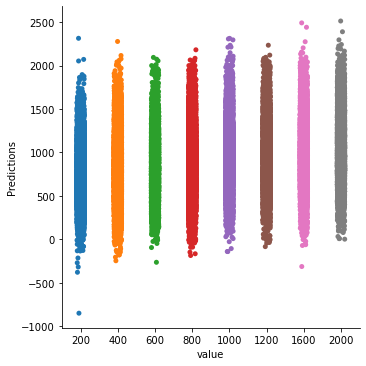

In [140]:
# Graph actual v. predicted values
sns.catplot(x='value',y='Predictions', data=actual_preds)
plt.savefig('catplot.png');

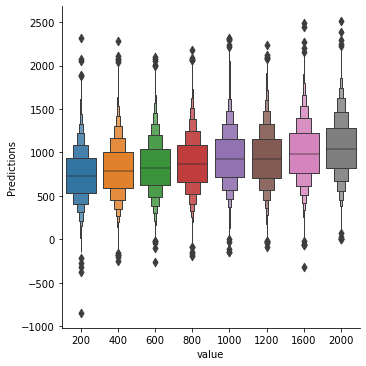

In [141]:
sns.catplot(x='value', y='Predictions', data=actual_preds, kind="boxen")
plt.savefig('catplot_boxen.png');

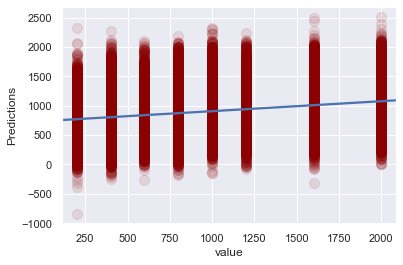

In [151]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_bothrounds.png');

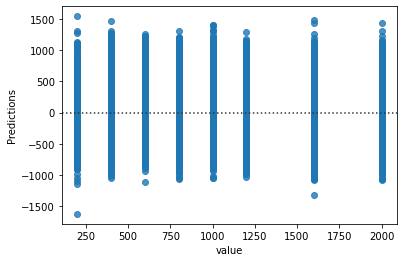

In [144]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=actual_preds)
plt.savefig('redidplot.png');

### Linear Regression Model on Separated Rounds

In [45]:
# Make separate data frames for Round 1 and Round 2 questions
round1 = df[df["round"] == 1]
round2 = df[df["round"] == 2]

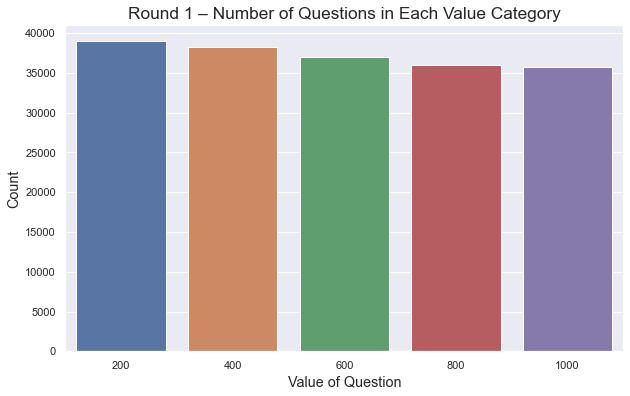

In [156]:
# Visualize the counts of each value category -- Round 1 Questions
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=round1, 
    x="value",
    order=round1.value.value_counts().index)

ax.set_title('Round 1 – Number of Questions in Each Value Category',fontsize='x-large')
ax.set_xlabel('Value of Question',fontsize='large')
ax.set_ylabel('Count',fontsize='large')

plt.show();

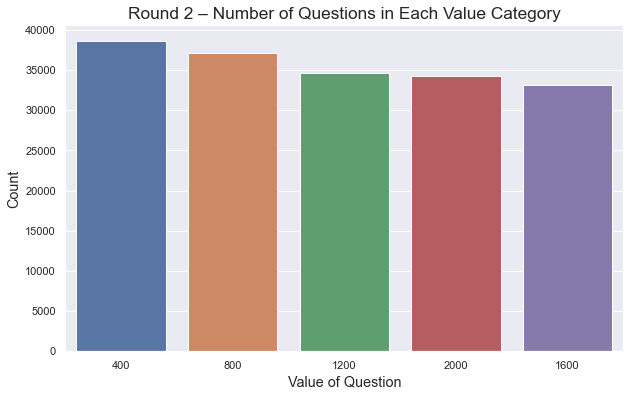

In [157]:
# Visualize the counts of each value category -- Round 2 Questions
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=round2, 
    x="value",
    order=round2.value.value_counts().index)

ax.set_title('Round 2 – Number of Questions in Each Value Category',fontsize='x-large')
ax.set_xlabel('Value of Question',fontsize='large')
ax.set_ylabel('Count',fontsize='large')

plt.show();

In [161]:
# Create feature and target variables for each round
X1 = round1['q_and_a']
X2 = round2['q_and_a']
y1 = round1['value']
y2 = round2['value']

In [162]:
# Create train-test splits for each round
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size= 0.25, random_state=54)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size= 0.25, random_state=54)

In [163]:
# Instantiate the vectorizer with stop words and bigrams and trigrams for Round 1
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3))

# Fit the vectorizer on X1_train and transform it
X1_train_vectorized = tfidf.fit_transform(X1_train)

# Fit the vectorizer on X2_train and transform it
X2_train_vectorized = tfidf.fit_transform(X2_train)

In [165]:
# Run 3 fold cross validation on linear regression model for Round 1
lr = LinearRegression()
lr_regression_cv1 = cross_val_score(lr, X1_train_vectorized, y1_train, cv=3, scoring=mape_score)
lr_regression_cv1

array([-64.73558114, -64.21752022, -63.40857503])

In [166]:
lr_regression_cv1.mean()

-64.12055879702949

In [169]:
# Run model on Round 1 test data
# Fit/transform training data to vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3))
X1_train_vectorized3 = tfidf.fit_transform(X1_train)

In [175]:
# Train the model using the Round 1 training set
lr.fit(X1_train_vectorized3, y1_train)

LinearRegression()

In [176]:
# Vectorize X_test
X1_test_vectorized3 = tfidf.transform(X1_test)

In [177]:
# Make predictions using the Round 1 test set
y1_pred = lr.predict(X1_test_vectorized3)

In [178]:
# Calculate mape for Round 1 test set
mape = mean_absolute_percentage_error(y1_test, y1_pred)
mape

65.67410061278271

In [ ]:
# Change y1_pred into a pandas df
df1_pred = pd.DataFrame(y1_pred, columns = ['Predictions'])

In [180]:
# # Create a df with actual and predicted Round 1 y_test values
actual1_preds = pd.concat([y1_test.reset_index(drop=True), df1_pred.reset_index(drop=True)], axis=1)
actual1_preds

,value,Predictions
0,200,447.289189
1,200,488.220795
2,400,650.649798
3,400,345.513954
4,1000,699.282769
...,...,...
46475,200,199.999988
46476,200,331.941341
46477,1000,345.796326
46478,1000,493.146857


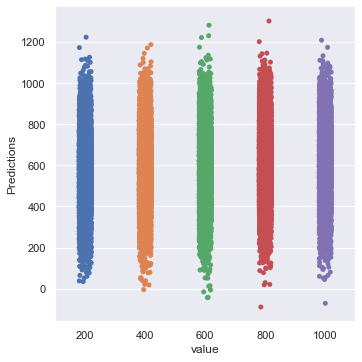

In [183]:
# Graph Round 1 actual v. predicted values
sns.catplot(x='value',y='Predictions', data=actual1_preds);

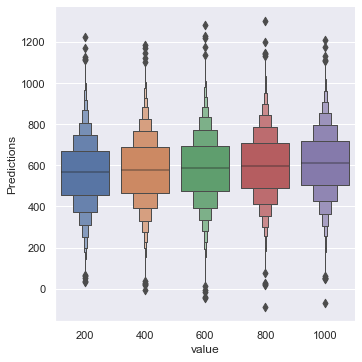

In [185]:
sns.catplot(x='value', y='Predictions', data=actual1_preds, kind="boxen");

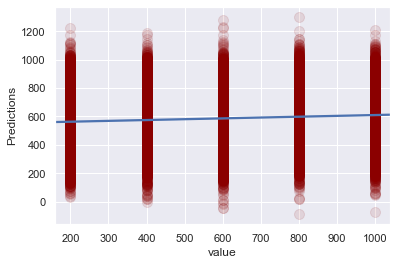

In [187]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=actual1_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False);

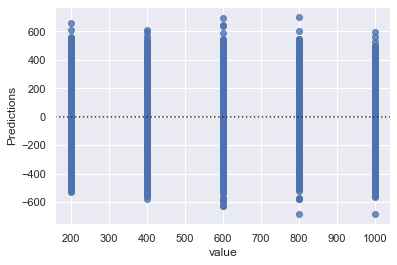

In [186]:
# Plot Round 1 residuals
sns.residplot(x='value',y='Predictions', data=actual1_preds);

In [167]:
# Run 3 fold cross validation on linear regression model for Round 2
lr_regression_cv2 = cross_val_score(lr, X2_train_vectorized, y2_train, cv=3, scoring=mape_score)
lr_regression_cv2

array([-63.90924281, -64.87995111, -63.77388397])

In [168]:
lr_regression_cv2.mean()

-64.18769263166668

In [188]:
# Run model on Round 2 test data
# Fit/transform training data to vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3))
X2_train_vectorized3 = tfidf.fit_transform(X2_train)

In [189]:
# Train the model using Round 2 training set
lr.fit(X2_train_vectorized3, y2_train)

LinearRegression()

In [190]:
# Vectorize X_test
X2_test_vectorized3 = tfidf.transform(X2_test)

In [191]:
# Make predictions using the test set
y2_pred = lr.predict(X2_test_vectorized3)

In [192]:
# Calculate mape for Round 2 test set
mape = mean_absolute_percentage_error(y2_test, y2_pred)
mape

66.49786468067931

In [ ]:
# Change y2_pred into a pandas df
df2_pred = pd.DataFrame(y2_pred, columns = ['Predictions'])

In [194]:
# Create a df with actual and predicted Round 2 y_test values
actual2_preds = pd.concat([y2_test.reset_index(drop=True), df2_pred.reset_index(drop=True)], axis=1)
actual2_preds

,value,Predictions
0,800,1660.499261
1,400,843.978760
2,1600,1413.782114
3,2000,1127.377134
4,1600,1223.707212
...,...,...
44457,1200,1588.856001
44458,1200,1353.466789
44459,800,1422.050950
44460,400,1422.228308


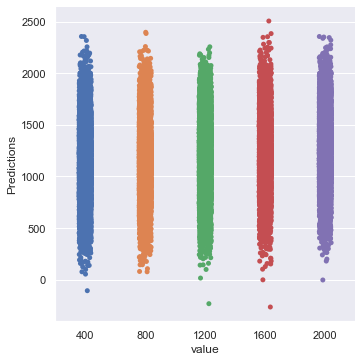

In [201]:
# Graph Round 2 actual v. predicted values
sns.catplot(x='value',y='Predictions', data=actual2_preds);

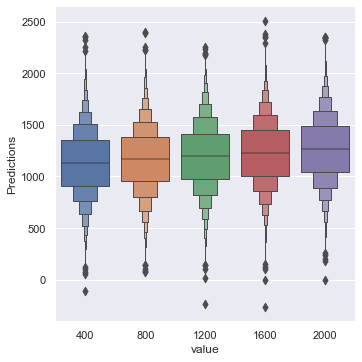

In [202]:
sns.catplot(x='value', y='Predictions', data=actual2_preds, kind="boxen");

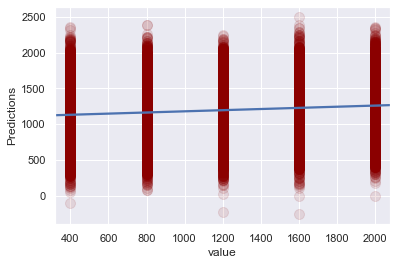

In [204]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=actual2_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False);

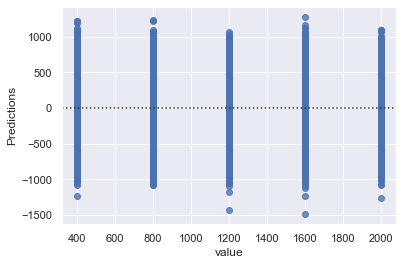

In [203]:
# Plot Round 2 residuals
sns.residplot(x='value',y='Predictions', data=actual2_preds);

## Ridge Regression Model

In [132]:
# Run baseline ridge regression model
ridge_regression = Ridge()
ridge_regression_cv = cross_val_score(ridge_regression, X_train_vectorized3, y_train, cv=2, scoring=mape_score)
ridge_regression_cv

array([-76.12930747, -76.49375165])

In [136]:
# Increase regularization strength
ridge_regression2 = Ridge(alpha=.8)
ridge_regression2_cv = cross_val_score(ridge_regression2, X_train_vectorized3, y_train, cv=2, scoring=mape_score)
ridge_regression2_cv

array([-76.00530929, -76.37220601])

In [137]:
# Decrease regularization strength
ridge_regression3 = Ridge(alpha=.3)
ridge_regression3_cv = cross_val_score(ridge_regression3, X_train_vectorized3, y_train, cv=2, scoring=mape_score)
ridge_regression3_cv

array([-75.6975788 , -76.06861204])

### Ridge Regression Separate Rounds

In [273]:
# Create train-test splits for each round
rr_X1_train, rr_X1_test, rr_y1_train, rr_y1_test = train_test_split(X1, y1, test_size= 0.25, random_state=54)
rr_X2_train, rr_X2_test, rr_y2_train, rr_y2_test = train_test_split(X2, y2, test_size= 0.25, random_state=54)

In [274]:
# Instantiate the vectorizer with stop words, bigrams and trigrams for Round 1
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3))

# Fit the vectorizer on X1_train and transform it
rr_X1_train_vectorized = tfidf.fit_transform(rr_X1_train)

# Fit the vectorizer on X2_train and transform it
rr_X2_train_vectorized = tfidf.fit_transform(rr_X2_train)

In [277]:
# Run 5 fold cross validation on ridge regression model for Round 1
rr_cv1 = cross_val_score(ridge_regression3, rr_X1_train_vectorized, rr_y1_train, cv=3, scoring=mape_score)
rr_cv1

array([-64.46556852, -63.48797282, -63.09903955])

In [278]:
rr_cv1.mean()

-63.68419362871125

In [279]:
# Run 5 fold cross validation on ridge regression model for Round 2
rr_cv2 = cross_val_score(ridge_regression3, rr_X2_train_vectorized, rr_y2_train, cv=3, scoring=mape_score)
rr_cv2

array([-64.17082496, -64.26888609, -63.77260046])

In [280]:
rr_cv2.mean()

-64.07077050400922

## Random Forest Regressor

In [205]:
# Test different tf-idf vectorizers to see which performs best using a random forest regressor model
random_forest = RandomForestRegressor(max_depth=2)
random_forest_cv1 = cross_val_score(random_forest, X_train_vectorized1, y_train, scoring=mape_score, cv=2)
random_forest_cv1

array([-80.67945364, -80.91869704])

In [206]:
print("RF1 Score: ", random_forest_cv1.mean())

RF1 Score:  -80.79907533949122


In [207]:
# Test different tf-idf vectorizers to see which performs best using a random forest regressor model
random_forest = RandomForestRegressor(max_depth=2, n_jobs=-1)
random_forest_cv2 = cross_val_score(random_forest, X_train_vectorized5, y_train, scoring=mape_score, cv=2)
random_forest_cv2

array([-80.68710168, -80.87173634])

In [208]:
print("RF1 Score: ", random_forest_cv1.mean())
print("RF2 Score: ", random_forest_cv2.mean())

RF1 Score:  -80.79907533949122
RF2 Score:  -80.7794190102111


In [209]:
# Test different tf-idf vectorizers to see which performs best using a random forest regressor model
random_forest = RandomForestRegressor(max_depth=2, n_jobs=-1)
random_forest_cv3 = cross_val_score(random_forest, X_train_vectorized6, y_train, scoring=mape_score, cv=2)
random_forest_cv3

array([-80.66863028, -80.93912899])

In [210]:
print("RF1 Score: ", random_forest_cv1.mean())
print("RF2 Score: ", random_forest_cv2.mean())
print("RF3 Score: ", random_forest_cv3.mean())

RF1 Score:  -80.79907533949122
RF2 Score:  -80.7794190102111
RF3 Score:  -80.80387963858655


In [211]:
# Test different tf-idf vectorizers to see which performs best using a random forest regressor model
random_forest = RandomForestRegressor(max_depth=2, n_jobs=-1)
random_forest_cv4 = cross_val_score(random_forest, X_train_vectorized7, y_train, scoring=mape_score, cv=2)
random_forest_cv4

array([-80.67126425, -80.91974604])

In [212]:
print("RF1 Score: ", random_forest_cv1.mean())
print("RF2 Score: ", random_forest_cv2.mean())
print("RF3 Score: ", random_forest_cv3.mean())
print("RF4 Score: ", random_forest_cv4.mean())

RF1 Score:  -80.79907533949122
RF2 Score:  -80.7794190102111
RF3 Score:  -80.80387963858655
RF4 Score:  -80.79550514527705


#### Hyperparamter Tuning Via Halving Randomized Search CV – Random Forest

In [32]:
# Create the random grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf = RandomForestRegressor()
half_search = HalvingRandomSearchCV(rf, random_grid, random_state=54, cv=3, n_candidates=70, verbose=5, error_score='raise')

# Fit the random search model
half_search.fit(X_train_vectorized8, y_train)

In [46]:
# Best parameters from random grid search

{'n_estimators': 136,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 32,
 'bootstrap': True}

In [49]:
# Run 2 fold cross validation for the  top parameter
rf2 = RandomForestRegressor(n_estimators=136, min_samples_split=2, min_samples_leaf=4, max_depth=32, bootstrap=True)

rf2_cv = cross_val_score(rf2, X_train_vectorized8, y_train, cv=2, scoring=mape_score)
rf2_cv

array([-79.62072485, -79.82914899])

In [51]:
print("Rf2 Score: ", rf2_cv.mean())

Rf2 Score:  -79.72493691807166


In [54]:
# Train the model using the training set
rf2.fit(X_train_vectorized8, y_train)

RandomForestRegressor(max_depth=32, min_samples_leaf=4, n_estimators=136)

In [55]:
#V ectorize X_test
X_test_vectorized = tfidf.transform(X_test)

In [56]:
# Make predictions using the testing set
y_pred = rf2.predict(X_test_vectorized)

In [57]:
# Calculate mape for tuned random forest test set
tunedrf_mape = mean_absolute_percentage_error(y_test, y_pred)
tunedrf_mape

80.04599985934023

In [ ]:
# Change y_pred into a pandas df
rf_pred = pd.DataFrame(y_pred, columns = ['Predictions'])

In [62]:
# Create a df with actual and predicted y_test values
rf_actual_preds = pd.concat([y_test.reset_index(drop=True), rf_pred.reset_index(drop=True)], axis=1)
rf_actual_preds

,value,Predictions
0,600,843.997049
1,1200,886.695026
2,400,887.850789
3,400,721.838644
4,400,843.997049
...,...,...
90937,1600,971.965668
90938,800,843.997049
90939,800,850.167592
90940,400,852.573251


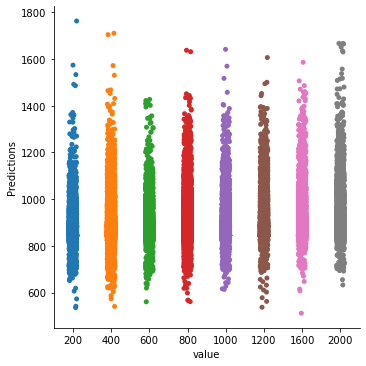

In [63]:
# Graph actual v. predicted values for random forest model
sns.catplot(x='value',y='Predictions', data=rf_actual_preds)
plt.savefig('catplot.png');

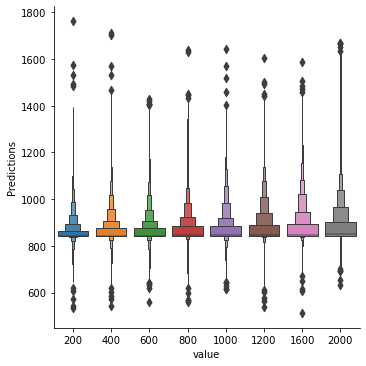

In [64]:
sns.catplot(x='value', y='Predictions', data=rf_actual_preds, kind="boxen")
plt.savefig('catplot_boxen.png');

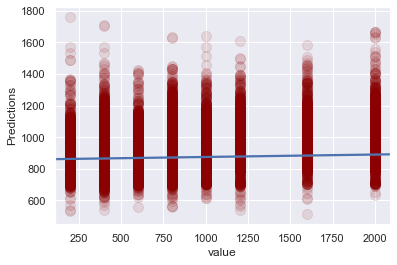

In [66]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=rf_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_bothrounds.png');

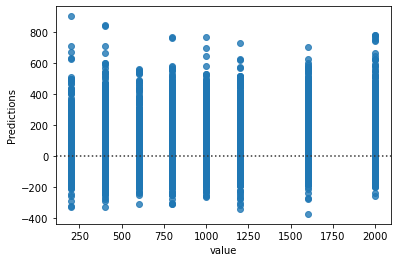

In [65]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=rf_actual_preds)
plt.savefig('redidplot.png');

### Random Forest Model on Separated Rounds

In [73]:
# Create train-test splits for each round
rf_X1_train, rf_X1_test, rf_y1_train, rf_y1_test = train_test_split(X1, y1, test_size= 0.25, random_state=54)
rf_X2_train, rf_X2_test, rf_y2_train, rf_y2_test = train_test_split(X2, y2, test_size= 0.25, random_state=54)

In [74]:
# Instantiate the vectorizer with stop words, bigrams and trigrams, and max features of 1000

tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3), max_features=1000)

# Fit the vectorizer on X1_train and transform it
rf_X1_train_vectorized = tfidf.fit_transform(rf_X1_train)

# Fit the vectorizer on X2_train and transform it
rf_X2_train_vectorized = tfidf.fit_transform(rf_X2_train)

In [76]:
# Run 2 fold cross validation on random forest model for Round 1
rf_cv1 = cross_val_score(rf2, rf_X1_train_vectorized, rf_y1_train, cv=2, scoring=mape_score)
rf_cv1

array([-64.38860759, -63.6871481 ])

In [77]:
rf_cv1.mean()

-64.03787784544394

In [78]:
# Run model on Round 1 test data
# Fit/transform training data to vectorizer
rf_X1_train_vectorized3 = tfidf.fit_transform(rf_X1_train)

In [79]:
# Train the model using the training set
rf2.fit(rf_X1_train_vectorized3, rf_y1_train)

RandomForestRegressor(max_depth=32, min_samples_leaf=4, n_estimators=136)

In [80]:
# Vectorize X_test
rf_X1_test_vectorized3 = tfidf.transform(rf_X1_test)

In [81]:
# Make predictions using the testing set
rf_y1_pred = rf2.predict(rf_X1_test_vectorized3)

In [82]:
# Calculate mape for tuned random forest Round 1 test set
round1_mape = mean_absolute_percentage_error(rf_y1_test, rf_y1_pred)
round1_mape

64.26321430735194

In [ ]:
# Change y1_pred into a pandas df
round1_df_pred = pd.DataFrame(rf_y1_pred, columns = ['Predictions'])

In [84]:
# Create a df with actual and predicted Round 1 y_test values
round1_actual_preds = pd.concat([rf_y1_test.reset_index(drop=True), round1_df_pred.reset_index(drop=True)], axis=1)
round1_actual_preds

,value,Predictions
0,200,580.614598
1,200,584.449341
2,400,584.609402
3,400,498.336863
4,1000,651.749248
...,...,...
46475,200,582.492647
46476,200,589.438035
46477,1000,576.026407
46478,1000,587.698273


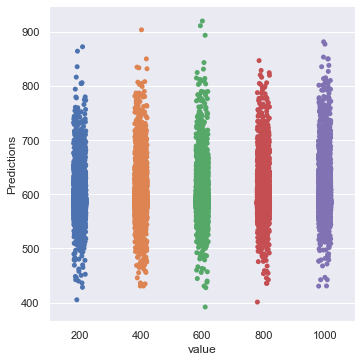

In [87]:
# Graph actual v. predicted values for Round 1 random forest model
sns.catplot(x='value',y='Predictions', data=round1_actual_preds);

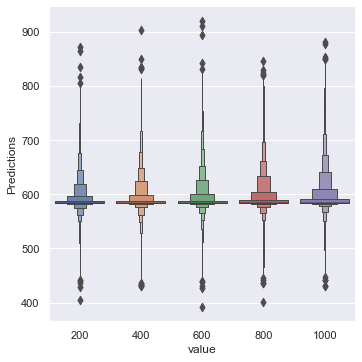

In [88]:
sns.catplot(x='value', y='Predictions', data=round1_actual_preds, kind="boxen");

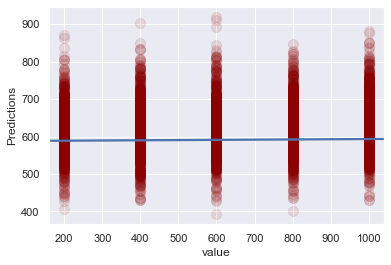

In [90]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=round1_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False);

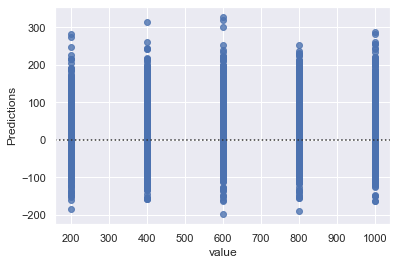

In [89]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=round1_actual_preds);

In [91]:
# Run 2 fold cross validation on random forest model for Round 2
rf_cv2 = cross_val_score(rf2, rf_X2_train_vectorized, rf_y2_train, cv=2, scoring=mape_score)
rf_cv2

array([-65.41945019, -64.71771109])

In [92]:
rf_cv2.mean()

-65.0685806357717

In [93]:
# Run model on Round 2 test data
# Fit/transform training data to vectorizer
rf_X2_train_vectorized3 = tfidf.fit_transform(rf_X2_train)

In [94]:
# Train the model using the training set
rf2.fit(rf_X2_train_vectorized3, rf_y2_train)

RandomForestRegressor(max_depth=32, min_samples_leaf=4, n_estimators=136)

In [95]:
# Vectorize X_test
rf_X2_test_vectorized3 = tfidf.transform(rf_X2_test)

In [96]:
# Make predictions using Round 2 test set
rf_y2_pred = rf2.predict(rf_X2_test_vectorized3)

In [97]:
# Calculate mape for tuned random forest Round 2 test set
round2_mape = mean_absolute_percentage_error(rf_y2_test, rf_y2_pred)
round2_mape

64.84891102069341

In [ ]:
# Change y2_pred into a pandas df
round2_df_pred = pd.DataFrame(rf_y2_pred, columns = ['Predictions'])

In [99]:
# Create a df with actual and predicted Round 2 y_test values
round2_actual_preds = pd.concat([rf_y2_test.reset_index(drop=True), round2_df_pred.reset_index(drop=True)], axis=1)
round2_actual_preds

,value,Predictions
0,800,1366.355351
1,400,1151.711630
2,1600,1151.711630
3,2000,1191.060159
4,1600,1207.197077
...,...,...
44457,1200,1151.711630
44458,1200,1151.711630
44459,800,1197.394734
44460,400,1241.048448


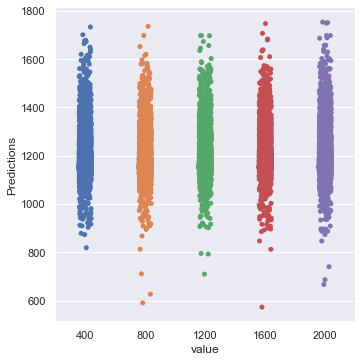

In [102]:
# Graph actual v. predicted values for Round 2 random forest model
sns.catplot(x='value',y='Predictions', data=round2_actual_preds);

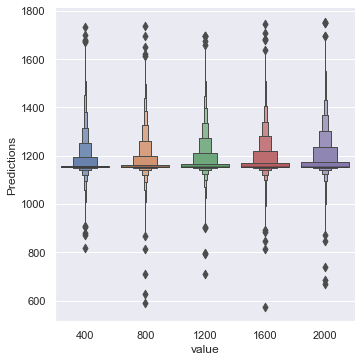

In [103]:
sns.catplot(x='value', y='Predictions', data=round2_actual_preds, kind="boxen");

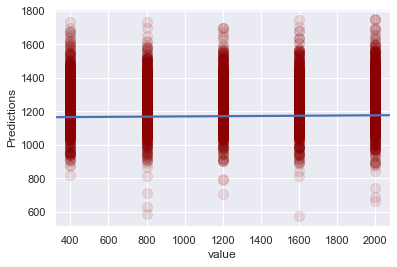

In [105]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=round2_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False);

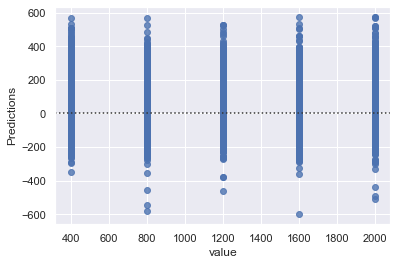

In [104]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=round2_actual_preds);

## Linear Support Vector Regression

In [32]:
# Test different tf-idf vectorizers to see which performs best using a Linear SVR model
linear_SVR_regressor = LinearSVR()
linearSVR_cv1 = cross_val_score(linear_SVR_regressor, X_train_vectorized1, y_train, scoring=mape_score, cv=2)
linearSVR_cv1

array([-71.84172978, -71.87221219])

In [33]:
print("Linear SVR1 Score: ", linearSVR_cv1.mean())

Linear SVR1 Score:  -71.85697098524378


In [34]:
# Test different tf-idf vectorizers to see which performs best using a Linear SVR model
linearSVR_cv2 = cross_val_score(linear_SVR_regressor, X_train_vectorized5, y_train, scoring=mape_score, cv=2)
linearSVR_cv2

array([-71.87444592, -71.86571355])

In [35]:
print("Linear SVR1 Score: ", linearSVR_cv1.mean())
print("Linear SVR2 Score: ", linearSVR_cv2.mean())

Linear SVR1 Score:  -71.85697098524378
Linear SVR2 Score:  -71.87007973666464


In [36]:
# Test different tf-idf vectorizers to see which performs best using a Linear SVR model
linearSVR_cv3 = cross_val_score(linear_SVR_regressor, X_train_vectorized6, y_train, scoring=mape_score, cv=2)
linearSVR_cv3

array([-71.78761128, -71.83579637])

In [37]:
print("Linear SVR1 Score: ", linearSVR_cv1.mean())
print("Linear SVR2 Score: ", linearSVR_cv2.mean())
print("Linear SVR3 Score: ", linearSVR_cv3.mean())

Linear SVR1 Score:  -71.85697098524378
Linear SVR2 Score:  -71.87007973666464
Linear SVR3 Score:  -71.81170382199815


In [38]:
# Test different tf-idf vectorizers to see which performs best using a Linear SVR model
linearSVR_cv4 = cross_val_score(linear_SVR_regressor, X_train_vectorized7, y_train, scoring=mape_score, cv=2)
linearSVR_cv4

array([-71.82340779, -71.75900693])

In [39]:
print("Linear SVR1 Score: ", linearSVR_cv1.mean())
print("Linear SVR2 Score: ", linearSVR_cv2.mean())
print("Linear SVR3 Score: ", linearSVR_cv3.mean())
print("Linear SVR: ", linearSVR_cv4.mean())

Linear SVR1 Score:  -71.85697098524378
Linear SVR2 Score:  -71.87007973666464
Linear SVR3 Score:  -71.81170382199815
Linear SVR:  -71.79120736097505


#### Hyperparamter Tuning Via Halving Randomized Search CV – Linear Support Vector Regression

In [48]:
# Create the random grid

# Number of iterations to be run
max_iter = [int(x) for x in np.linspace(start = 800, stop = 2000, num = 10)]
# Select the loss function
loss = ['epsilon_insensitive', 'squared_epsilon_insensitive']
# Tolerance for stopping criteria
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
# Epsilon-insensitive loss function
epsilon = [0, 0.01, 0.1, 0.5, 1, 2, 4]
# Regularization parameter
C = [100, 10, 1, .15, .1, .01]

random_grid = {'max_iter': max_iter,
               'loss': loss,
               'tol': tol,
               'epsilon': epsilon,
               'C': C}
print(random_grid)

{'max_iter': [800, 933, 1066, 1200, 1333, 1466, 1600, 1733, 1866, 2000], 'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1], 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4], 'C': [100, 10, 1, 0.15, 0.1, 0.01]}


In [ ]:
linearsvr_half_search = HalvingRandomSearchCV(linear_SVR_regressor, random_grid, random_state=54, cv=3, n_candidates=60, verbose=5, error_score='raise')

# Fit the random search model
linearsvr_half_search.fit(X_train_vectorized7, y_train)

In [50]:
linearsvr_half_search.best_params_

{'tol': 1e-06,
 'max_iter': 800,
 'loss': 'squared_epsilon_insensitive',
 'epsilon': 1,
 'C': 10}

In [46]:
# Run 5-fold cv for the top parameter
tuned_linear_SVR_regressor = LinearSVR(tol=1e-06, max_iter=800, loss='squared_epsilon_insensitive', epsilon=1, C=10)
tuned_linear_SVR_regressor_cv = cross_val_score(tuned_linear_SVR_regressor, X_train_vectorized7, y_train, cv=5, scoring=mape_score)
tuned_linear_SVR_regressor_cv

array([-77.43350851, -77.55799911, -77.83351029, -77.91630043,
       -77.21242738])

In [51]:
print("Tuned Linear SVR Regressor Score: ", tuned_linear_SVR_regressor_cv.mean())

Tuned Linear SVR Regressor Score:  -77.59074914521008


In [52]:
# Run 5 fold cross validation on an untuned Linear SVR model for comparison
untuned_linear_SVR_regressor = LinearSVR()
untuned_linear_SVR_regressor_cv = cross_val_score(untuned_linear_SVR_regressor, X_train_vectorized7, y_train, cv=5, scoring=mape_score)
untuned_linear_SVR_regressor_cv

array([-71.67064646, -71.83401068, -72.02405938, -71.81783842,
       -71.33833217])

In [53]:
print("Untuned Linear SVR Regressor Score: ", untuned_linear_SVR_regressor_cv.mean())

Untuned Linear SVR Regressor Score:  -71.73697742394634


In [54]:
# Since the untuned model performed better, it will be used to train the model
untuned_linear_SVR_regressor.fit(X_train_vectorized7, y_train)

LinearSVR()

In [55]:
# Vectorize X_test
X_test_vectorized = tfidf.transform(X_test)

In [56]:
# Make predictions using the test set
y_pred = untuned_linear_SVR_regressor.predict(X_test_vectorized)

In [57]:
# Calculate mape for linear SVR test data
untuned_linear_SVR_mape = mean_absolute_percentage_error(y_test, y_pred)
untuned_linear_SVR_mape

72.09830487194093

In [ ]:
# Change y_pred into a pandas df
linear_SVR_pred = pd.DataFrame(y_pred, columns = ['Predictions'])

In [60]:
# Create a df with actual and predicted y_test values
linear_SVR_actual_preds = pd.concat([y_test.reset_index(drop=True), linear_SVR_pred.reset_index(drop=True)], axis=1)
linear_SVR_actual_preds

,value,Predictions
0,600,799.368879
1,1200,804.059542
2,400,796.150338
3,400,794.426223
4,400,800.891026
...,...,...
90937,1600,799.713375
90938,800,803.704877
90939,800,807.131862
90940,400,796.062762


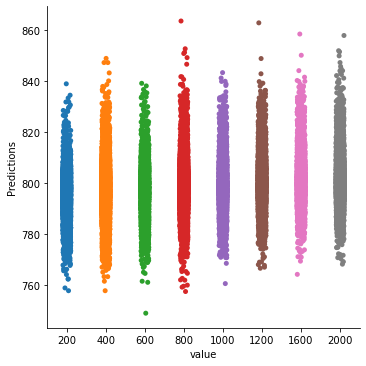

In [61]:
# Graph actual v. predicted values for linear SVR model
sns.catplot(x='value',y='Predictions', data=linear_SVR_actual_preds)
plt.savefig('catplot.png');

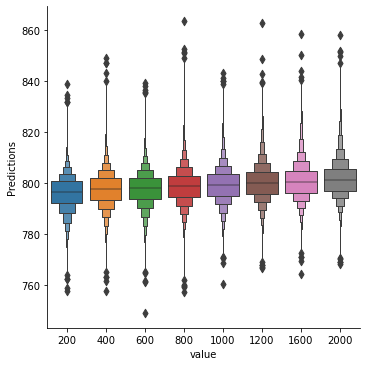

In [62]:
sns.catplot(x='value', y='Predictions', data=linear_SVR_actual_preds, kind="boxen")
plt.savefig('catplot_boxen.png');

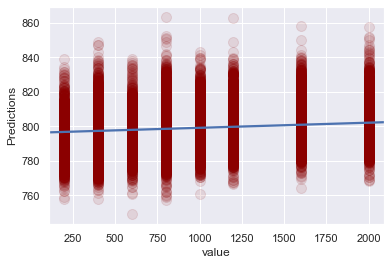

In [65]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=linear_SVR_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_bothrounds.png');

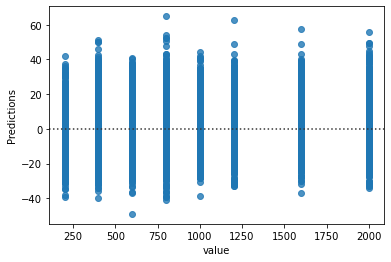

In [64]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=linear_SVR_actual_preds)
plt.savefig('redidplot.png');

### Linear SVR on Separated Rounds

In [70]:
# Create train-test splits for each round
svr_X1_train, svr_X1_test, svr_y1_train, svr_y1_test = train_test_split(X1, y1, test_size= 0.25, random_state=54)
svr_X2_train, svr_X2_test, svr_y2_train, svr_y2_test = train_test_split(X2, y2, test_size= 0.25, random_state=54)

In [71]:
# Instantiate the vectorizer with stop words, bigrams and trigrams, and max features of 5000
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3), max_features=5000)

# Fit the vectorizer on X1_train and transform it
svr_X1_train_vectorized = tfidf.fit_transform(svr_X1_train)

# Fit the vectorizer on X2_train and transform it
svr_X2_train_vectorized = tfidf.fit_transform(svr_X2_train)

In [73]:
# Run 2 fold cross validation on Round 1 quesions
svr2_cv1 = cross_val_score(untuned_linear_SVR_regressor, svr_X1_train_vectorized, svr_y1_train, cv=2, scoring=mape_score)
svr2_cv1

array([-64.92080701, -64.48461037])

In [74]:
svr2_cv1.mean()

-64.70270868723352

In [75]:
# Run model on Round 1 test data
# Fit/transform training data to vectorizer
svr_X1_train_vectorized3 = tfidf.fit_transform(svr_X1_train)

In [76]:
# Train the model using the training set
untuned_linear_SVR_regressor.fit(svr_X1_train_vectorized3, svr_y1_train)

LinearSVR()

In [77]:
# Vectorize X_test
svr_X1_test_vectorized3 = tfidf.transform(svr_X1_test)

In [78]:
# Make predictions using the test set
svr_y1_pred = untuned_linear_SVR_regressor.predict(svr_X1_test_vectorized3)

In [79]:
# Calculate mape for linear SVR Round 1 test data
svr_round1_mape = mean_absolute_percentage_error(svr_y1_test, svr_y1_pred)
svr_round1_mape

64.9615070655669

In [ ]:
# Change y1_pred into a pandas df
svr_round1_df_pred = pd.DataFrame(svr_y1_pred, columns = ['Predictions'])

In [81]:
# Create a df with actual and predicted Round 1 y_test values
svr_round1_actual_preds = pd.concat([svr_y1_test.reset_index(drop=True), svr_round1_df_pred.reset_index(drop=True)], axis=1)
svr_round1_actual_preds

,value,Predictions
0,200,597.214814
1,200,598.152652
2,400,600.464506
3,400,598.884601
4,1000,603.965340
...,...,...
46475,200,598.135903
46476,200,600.072184
46477,1000,596.258416
46478,1000,600.113059


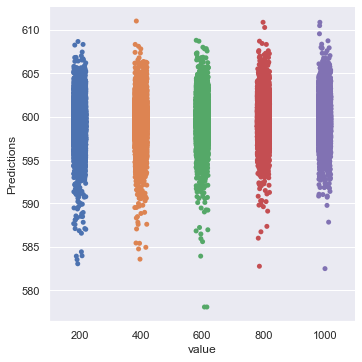

In [82]:
# Graph actual v. predicted values for Round 1 linear SVR model
sns.catplot(x='value',y='Predictions', data=svr_round1_actual_preds);

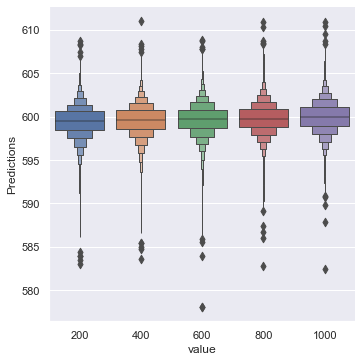

In [83]:
sns.catplot(x='value', y='Predictions', data=svr_round1_actual_preds, kind="boxen");

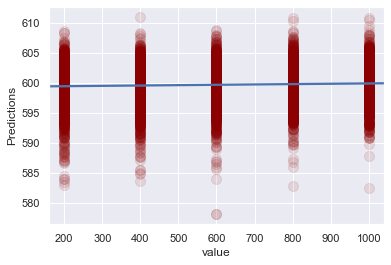

In [85]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=svr_round1_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False);

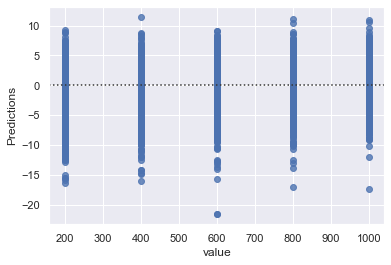

In [84]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=svr_round1_actual_preds);

In [86]:
# Run 2 fold cross validation on Round 2 quesions
svr_cv2 = cross_val_score(untuned_linear_SVR_regressor, svr_X2_train_vectorized, svr_y2_train, cv=2, scoring=mape_score)
svr_cv2

array([-66.63616185, -65.95596046])

In [87]:
svr_cv2.mean()

-66.29606115455216

In [88]:
# Run model on Round 2 test data
# Fit/transform training data to vectorizer
svr_X2_train_vectorized3 = tfidf.fit_transform(svr_X2_train)

In [89]:
# Train the model using the training set
untuned_linear_SVR_regressor.fit(svr_X2_train_vectorized3, svr_y2_train)

LinearSVR()

In [90]:
# Vectorize X_test
svr_X2_test_vectorized3 = tfidf.transform(svr_X2_test)

In [91]:
# Make predictions using the test set
svr_y2_pred = untuned_linear_SVR_regressor.predict(svr_X2_test_vectorized3)

In [92]:
# Calculate mape for linear SVR Round 2 test data
svr_round2_mape = mean_absolute_percentage_error(svr_y2_test, svr_y2_pred)
svr_round2_mape

65.9615507875322

In [ ]:
# Change y2_pred into a pandas df
svr_round2_df_pred = pd.DataFrame(svr_y2_pred, columns = ['Predictions'])

In [94]:
# Create a df with actual and predicted Round 2 y_test values
svr_round2_actual_preds = pd.concat([svr_y2_test.reset_index(drop=True), svr_round2_df_pred.reset_index(drop=True)], axis=1)
svr_round2_actual_preds

,value,Predictions
0,800,1207.068618
1,400,1198.276941
2,1600,1202.882384
3,2000,1198.814933
4,1600,1200.386175
...,...,...
44457,1200,1195.239337
44458,1200,1200.255037
44459,800,1201.441374
44460,400,1199.930170


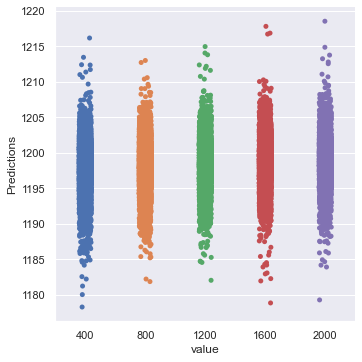

In [95]:
# Graph actual v. predicted values for Round 2 linear SVR model
sns.catplot(x='value',y='Predictions', data=svr_round2_actual_preds);

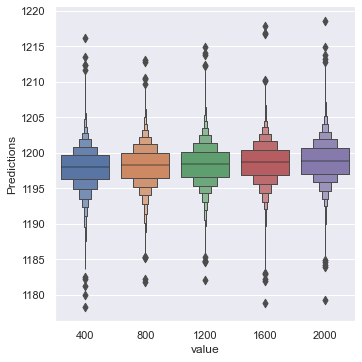

In [96]:
sns.catplot(x='value', y='Predictions', data=svr_round2_actual_preds, kind="boxen");

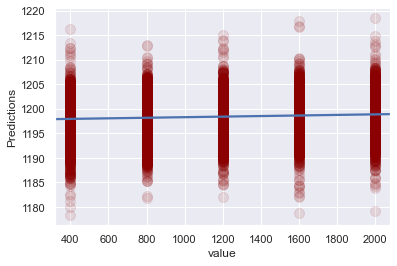

In [98]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=svr_round2_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False);

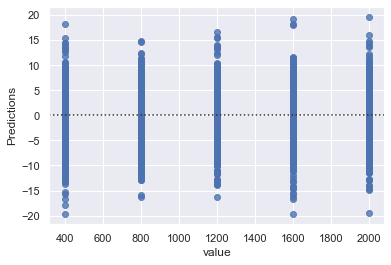

In [97]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=svr_round2_actual_preds);

## Gradient Boosting Regressor

In [33]:
# Test different tf-idf vectorizers to see which performs best using a Gradient Boosting model
basic_gbr = GradientBoostingRegressor()
basic_gbr_cv1 = cross_val_score(basic_gbr, X_train_vectorized5, y_train, scoring=mape_score, cv=2)
basic_gbr_cv1

array([-80.11488566, -80.37875641])

In [34]:
print("Gradient Boosting1 Score: ", basic_gbr_cv1.mean())

Gradient Boosting1 Score:  -80.24682103505035


In [35]:
# Test different tf-idf vectorizers to see which performs best using a Gradient Boosting model
basic_gbr_cv2 = cross_val_score(basic_gbr, X_train_vectorized6, y_train, scoring=mape_score, cv=2)
basic_gbr_cv2

array([-80.10908321, -80.38423997])

In [36]:
print("Gradient Boosting1 Score: ", basic_gbr_cv1.mean())
print("Gradient Boosting2 Score: ", basic_gbr_cv2.mean())

Gradient Boosting1 Score:  -80.24682103505035
Gradient Boosting2 Score:  -80.24666158799374


In [37]:
# Test different tf-idf vectorizers to see which performs best using a Gradient Boosting model
basic_gbr_cv3 = cross_val_score(basic_gbr, X_train_vectorized7, y_train, scoring=mape_score, cv=2)
basic_gbr_cv3

array([-80.08916658, -80.37194915])

In [38]:
print("Gradient Boosting1 Score: ", basic_gbr_cv1.mean())
print("Gradient Boosting2 Score: ", basic_gbr_cv2.mean())
print("Gradient Boosting3 Score: ", basic_gbr_cv3.mean())

Gradient Boosting1 Score:  -80.24682103505035
Gradient Boosting2 Score:  -80.24666158799374
Gradient Boosting3 Score:  -80.23055786479281


In [27]:
# Test different tf-idf vectorizers to see which performs best using a Gradient Boosting model
basic_gbr_cv5 = cross_val_score(basic_gbr, X_train_vectorized8, y_train, scoring=mape_score, cv=2)
basic_gbr_cv5

array([-80.10348619, -80.39592409])

In [39]:
print("Gradient Boosting1 Score: ", basic_gbr_cv1.mean())
print("Gradient Boosting2 Score: ", basic_gbr_cv2.mean())
print("Gradient Boosting3 Score: ", basic_gbr_cv3.mean())
print("Gradient Boosting4 Score: ", basic_gbr_cv5.mean())

Gradient Boosting1 Score:  -80.24682103505035
Gradient Boosting2 Score:  -80.24666158799374
Gradient Boosting3 Score:  -80.23055786479281
Gradient Boosting4 Score:  -80.24970513942583


#### Hyperparamter Tuning Via Halving Randomized Search CV – Gradient Boosting

In [62]:
# Create the random grid

# Select the loss function
loss = ['ls', 'lad', 'huber']
# Learning rate
learning_rate = [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2]
# Minimum samples/leaf
min_samples_leaf = [1, 3, 5, 7, 10, 12]
# Minimum number of samples required to split an internal node
min_samples_split = [2, 3, 5, 7, 10, 12]
# Number of estimators
n_estimators = [90, 100, 150, 200, 300]
# Max depth
max_depth = [3, 5, 8, 10]
# Max features
max_features = ['sqrt', 'log2', 'auto']

random_grid = {'loss': loss,
               'learning_rate': learning_rate,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features}
               
print(random_grid)

{'loss': ['ls', 'lad', 'huber'], 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], 'min_samples_leaf': [1, 3, 5, 7, 10, 12], 'min_samples_split': [2, 3, 5, 7, 10, 12], 'n_estimators': [90, 100, 150, 200, 300], 'max_depth': [3, 5, 8, 10], 'max_features': ['sqrt', 'log2', 'auto']}


In [ ]:
gb_half_search = HalvingRandomSearchCV(basic_gbr, random_grid, random_state=54, cv=3, n_candidates=60, verbose=5, error_score='raise')

# Fit the random search model
gb_half_search.fit(X_train_vectorized8, y_train)

In [64]:
gb_half_search.best_params_

{'n_estimators': 90,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 5,
 'loss': 'ls',
 'learning_rate': 0.1}

In [66]:
# Run a 5 fold cross validation for the top parameter
tuned_gb_regressor = GradientBoostingRegressor(n_estimators=90, min_samples_split=12, min_samples_leaf=5, max_features='sqrt', max_depth=5, loss='ls', learning_rate=0.1)
tuned_gb_regressor_cv = cross_val_score(tuned_gb_regressor, X_train_vectorized8, y_train, cv=5, scoring=mape_score)
tuned_gb_regressor_cv

array([-79.99717504, -80.09331768, -80.5789476 , -80.19678648,
       -79.67112595])

In [67]:
print("Tuned Gradient Boosting Score: ", tuned_gb_regressor_cv.mean())

Tuned Gradient Boosting Score:  -80.10747055015028


In [68]:
# Train the model using the training set
tuned_gb_regressor.fit(X_train_vectorized8, y_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=5,
                          min_samples_split=12, n_estimators=90)

In [73]:
# Vectorize X_test
X_test_vectorized = tfidf.transform(X_test)

In [75]:
# Make predictions using the test set
y_pred = tuned_gb_regressor.predict(X_test_vectorized)

In [76]:
# Calculate mape for gradient boosting test data
tuned_GB_regressor_mape = mean_absolute_percentage_error(y_test, y_pred)
tuned_GB_regressor_mape

80.4482177285296

In [ ]:
# Change y_pred into a pandas df
GB_regressor_pred = pd.DataFrame(y_pred, columns = ['Predictions'])

In [79]:
# Create a df with actual and predicted y_test values
GB_regressor_actual_preds = pd.concat([y_test.reset_index(drop=True), GB_regressor_pred.reset_index(drop=True)], axis=1)
GB_regressor_actual_preds

,value,Predictions
0,600,855.284405
1,1200,945.882864
2,400,914.567875
3,400,808.337911
4,400,855.284405
...,...,...
90937,1600,882.107396
90938,800,855.284405
90939,800,908.399485
90940,400,859.623534


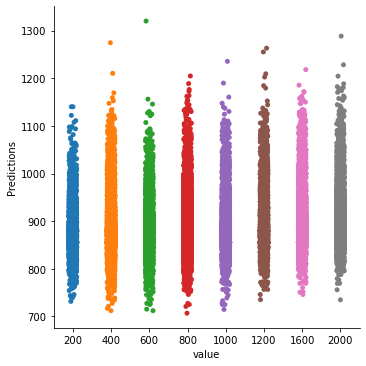

In [80]:
# Graph actual v. predicted values for gradient boosting model
sns.catplot(x='value',y='Predictions', data=GB_regressor_actual_preds)
plt.savefig('catplot.png');

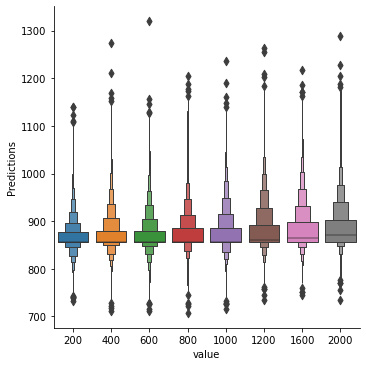

In [81]:
sns.catplot(x='value', y='Predictions', data=GB_regressor_actual_preds, kind="boxen")
plt.savefig('catplot_boxen.png');

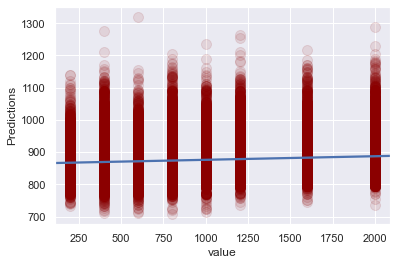

In [83]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=GB_regressor_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_bothrounds.png');

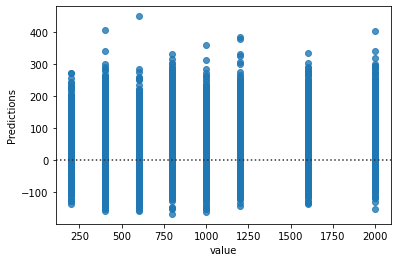

In [82]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=GB_regressor_actual_preds)
plt.savefig('redidplot.png');

### Gradient Boosting on Separated Rounds

In [88]:
# Create train-test splits for each round
gb_X1_train, gb_X1_test, gb_y1_train, gb_y1_test = train_test_split(X1, y1, test_size= 0.25, random_state=54)
gb_X2_train, gb_X2_test, gb_y2_train, gb_y2_test = train_test_split(X2, y2, test_size= 0.25, random_state=54)

In [90]:
# Instantiate the vectorizer with stop words, bigrams and trigrams, and max features of 1000 for Round 1
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 3), max_features=1000)

# Fit the vectorizer on X1_train and transform it
gb_X1_train_vectorized = tfidf.fit_transform(gb_X1_train)

# Fit the vectorizer on X2_train and transform it
gb_X2_train_vectorized = tfidf.fit_transform(gb_X2_train)

In [91]:
# Run a 2 fold cross validation for Round 1 questions
gb_cv1 = cross_val_score(tuned_gb_regressor, gb_X1_train_vectorized, gb_y1_train, cv=2, scoring=mape_score)
gb_cv1

array([-64.34017463, -63.62411524])

In [92]:
gb_cv1.mean()

-63.98214493493205

In [93]:
# Run model on Round 1 test data
# Fit/transform training data to vectorizer
gb_X1_train_vectorized3 = tfidf.fit_transform(gb_X1_train)

In [94]:
# Train the model using the training set
tuned_gb_regressor.fit(gb_X1_train_vectorized3, gb_y1_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=5,
                          min_samples_split=12, n_estimators=90)

In [95]:
# Vectorize X_test
gb_X1_test_vectorized3 = tfidf.transform(gb_X1_test)

In [97]:
# Make predictions using the test set
gb_y1_pred = tuned_gb_regressor.predict(gb_X1_test_vectorized3)

In [98]:
# Calculate mape for gradient boosting Round 1 test data
gb_round1_mape = mean_absolute_percentage_error(gb_y1_test, gb_y1_pred)
gb_round1_mape

64.21034033515778

In [ ]:
# Change y1_pred into a pandas df
gb_round1_df_pred = pd.DataFrame(gb_y1_pred, columns = ['Predictions'])

In [100]:
# Create a df with actual and predicted Round 1 y_test values
gb_round1_actual_preds = pd.concat([gb_y1_test.reset_index(drop=True), gb_round1_df_pred.reset_index(drop=True)], axis=1)
gb_round1_actual_preds

,value,Predictions
0,200,586.422590
1,200,584.461102
2,400,586.422590
3,400,572.303499
4,1000,638.970901
...,...,...
46475,200,586.422590
46476,200,604.484994
46477,1000,585.741880
46478,1000,586.422590


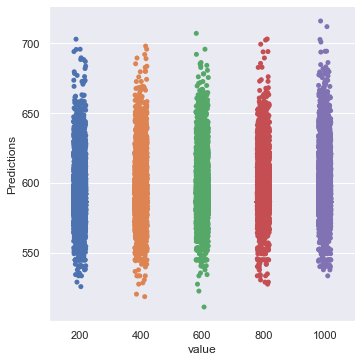

In [101]:
# Graph actual v. predicted values for Round 1 gradient boosting model
sns.catplot(x='value',y='Predictions', data=gb_round1_actual_preds);

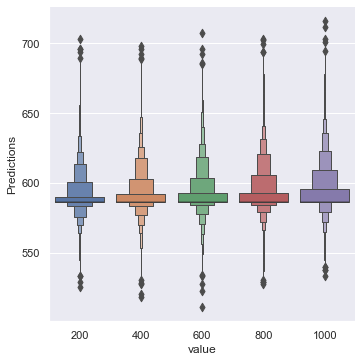

In [102]:
sns.catplot(x='value', y='Predictions', data=gb_round1_actual_preds, kind="boxen");

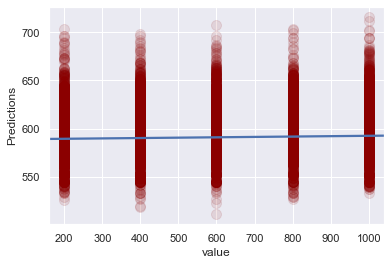

In [104]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=gb_round1_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False);

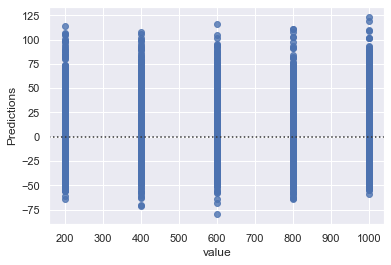

In [103]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=gb_round1_actual_preds);

In [105]:
# Run 2 fold cross validation on Round 2 questions
gb_cv2 = cross_val_score(tuned_gb_regressor, gb_X2_train_vectorized, gb_y2_train, cv=2, scoring=mape_score)
gb_cv2

array([-65.35865446, -64.6375621 ])

In [106]:
gb_cv2.mean()

-64.99810827922207

In [107]:
# Run model on Round 2 test data
# Fit/transform training data to vectorizer
gb_X2_train_vectorized3 = tfidf.fit_transform(gb_X2_train)

In [109]:
# Train the model using the training set
tuned_gb_regressor.fit(gb_X2_train_vectorized3, gb_y2_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=5,
                          min_samples_split=12, n_estimators=90)

In [112]:
# Vectorize X_test
gb_X2_test_vectorized3 = tfidf.transform(gb_X2_test)

In [113]:
# Make predictions using the test set
gb_y2_pred = tuned_gb_regressor.predict(gb_X2_test_vectorized3)

In [114]:
# Calculate mape for gradient boosting Round 2 test data
gb_round2_mape = mean_absolute_percentage_error(gb_y2_test, gb_y2_pred)
gb_round2_mape

64.69379818695158

In [ ]:
# Change y2_pred into a pandas df
gb_round2_df_pred = pd.DataFrame(gb_y2_pred, columns = ['Predictions'])

In [116]:
# Create a df with actual and predicted Round2y_test values
gb_round2_actual_preds = pd.concat([gb_y2_test.reset_index(drop=True), gb_round2_df_pred.reset_index(drop=True)], axis=1)
gb_round2_actual_preds

,value,Predictions
0,800,1290.081813
1,400,1158.240252
2,1600,1158.240252
3,2000,1181.421646
4,1600,1185.035675
...,...,...
44457,1200,1148.296777
44458,1200,1158.240252
44459,800,1257.144411
44460,400,1205.910524


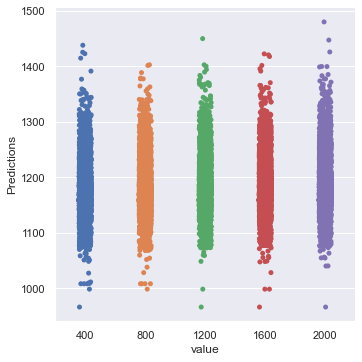

In [117]:
# Graph actual v. predicted values for Round 2 gradient boosting model
sns.catplot(x='value',y='Predictions', data=gb_round2_actual_preds);

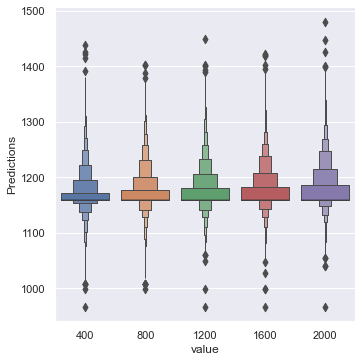

In [118]:
sns.catplot(x='value', y='Predictions', data=gb_round2_actual_preds, kind="boxen");

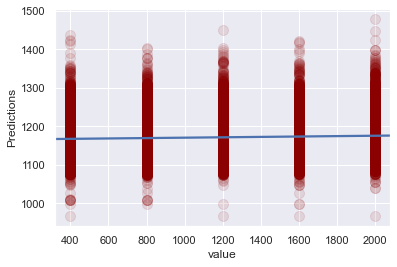

In [120]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=gb_round2_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False);

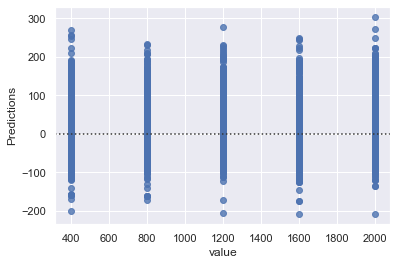

In [119]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=gb_round2_actual_preds);

## Neural Network

In [122]:
#Instantiate the vector with stop words, bigrams, and max_features=1000
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 2), max_features=1000)

# Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train).todense()

In [123]:
# Initialize a sequential model
model = Sequential()

# Three layers with relu activation
model.add(layers.Dense(20, input_dim=1000, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

In [127]:
# Compile the keras model
model.compile(loss='mape', optimizer='adam', metrics=['mape'])

In [128]:
# Fit the keras model on the dataset
nn_model1 = model.fit(X_train_vectorized, y_train, epochs=15, batch_size=100)

Epoch 1/15
2729/2729 [==============================] - 13s 5ms/step - loss: 53.1442 - mape: 53.1442
Epoch 2/15
2729/2729 [==============================] - 12s 4ms/step - loss: 51.2910 - mape: 51.2910
Epoch 3/15
2729/2729 [==============================] - 11s 4ms/step - loss: 51.0454 - mape: 51.0454 0s - loss: 51.0629 - mape: 51.06 -
Epoch 4/15
2729/2729 [==============================] - 11s 4ms/step - loss: 50.9285 - mape: 50.9285
Epoch 5/15
2729/2729 [==============================] - 11s 4ms/step - loss: 50.8697 - mape: 50.8697
Epoch 6/15
2729/2729 [==============================] - 11s 4ms/step - loss: 50.7979 - mape: 50.7979
Epoch 14/15
2729/2729 [==============================] - 10s 4ms/step - loss: 50.7951 - mape: 50.7951
Epoch 15/15
2729/2729 [==============================] - 10s 4ms/step - loss: 50.7920 - mape: 50.7920


In [129]:
# Final mape
mape= nn_model1.history['mape'][-1]
mape

50.791988372802734

In [189]:
# Add more layers
model2 = Sequential()

# Five layers with relu activation
model2.add(layers.Dense(20, input_dim=len(tfidf.vocabulary_), activation='relu'))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))

#compile the keras model
model2.compile(loss='mape', optimizer='adam', metrics=['mape'])

In [ ]:
# Fit the keras model on the dataset
nn_model2 = model2.fit(X_train_vectorized, y_train, epochs=15, batch_size=100)

In [132]:
# Final mape
mape2= nn_model2.history['mape'][-1]
mape2

50.600460052490234

That's ever so slightly better! Let's try more epochs and a bigger batch size.

In [ ]:
# Fit the keras model on the dataset
nn_model2 = model2.fit(X_train_vectorized, y_train, epochs=30, batch_size=200)

Epoch 1/30
1365/1365 [==============================] - 9s 6ms/step - loss: 60.5227 - mape: 60.5227
Epoch 2/30
1365/1365 [==============================] - 8s 6ms/step - loss: 51.9515 - mape: 51.9515
Epoch 3/30
1365/1365 [==============================] - 9s 6ms/step - loss: 51.5893 - mape: 51.5893: 0s - loss: 51.6091 - m
Epoch 4/30
1365/1365 [==============================] - 10s 7ms/step - loss: 51.3373 - mape: 51.3373
Epoch 5/30
1365/1365 [==============================] - 12s 9ms/step - loss: 51.1293 - mape: 51.1293
Epoch 6/30
1365/1365 [==============================] - 9s 7ms/step - loss: 50.9400 - mape: 50.9400
Epoch 7/30
1365/1365 [==============================] - 10s 7ms/step - loss: 50.8403 - mape: 50.8403
Epoch 8/30
1365/1365 [==============================] - 9s 7ms/step - loss: 50.8204 - mape: 50.8204
Epoch 9/30
1365/1365 [==============================] - 9s 7ms/step - loss: 50.7378 - mape: 50.7378
Epoch 17/30
1365/1365 [==============================] - 9s 7ms/step - lo

In [191]:
# Final mape
mape3= nn_model2.history['mape'][-1]
mape3 

50.440086364746094

Another small move in the right direction.

In [ ]:
# Regularize the model with dropout
model3 = Sequential()

# Five layers with relu activation and dropout
model3.add(layers.Dense(20, input_dim=1000, activation='relu'))
model.add(Dropout(0.5))
model3.add(layers.Dense(20, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))
model.add(Dropout(0.5))
model3.add(layers.Dense(1, activation='relu'))

# Compile the keras model
model3.compile(loss='mape', optimizer='adam', metrics=['mape'])

# Fit the keras model on the dataset
nn_model3 = model3.fit(X_train_vectorized, y_train, epochs=30, batch_size=200)

Epoch 1/30
1365/1365 [==============================] - 8s 6ms/step - loss: 57.6332 - mape: 57.6332
Epoch 2/30
1365/1365 [==============================] - 7s 5ms/step - loss: 51.6549 - mape: 51.6549
Epoch 3/30
1365/1365 [==============================] - 8s 6ms/step - loss: 51.3066 - mape: 51.3066
Epoch 4/30
1365/1365 [==============================] - 10s 7ms/step - loss: 51.0574 - mape: 51.0574 0s - loss: 51.04
Epoch 5/30
1365/1365 [==============================] - 8s 6ms/step - loss: 50.9002 - mape: 50.9002
Epoch 6/30
1365/1365 [==============================] - 7s 5ms/step - loss: 50.8597 - mape: 50.8597
Epoch 7/30
1365/1365 [==============================] - 7s 5ms/step - loss: 50.8480 - mape: 50.8480
Epoch 8/30
1365/1365 [==============================] - 15s 11ms/step - loss: 50.7833 - mape: 50.7833
Epoch 17/30
1365/1365 [==============================] - 17s 12ms/step - loss: 50.7684 - mape: 50.7684
Epoch 18/30
1365/1365 [==============================] - 15s 11ms/step - loss

In [136]:
# Final mape
mape4= nn_model3.history['mape'][-1]
mape4

50.561397552490234

In [137]:
# Regularize the model with L1
model4 = Sequential()

# Six layers with relu activation
model4.add(layers.Dense(20, input_dim=1000, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
model4.add(layers.Dense(20, activation='relu'))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(1, activation='relu'))

# Compile the keras model
model4.compile(loss='mape', optimizer='adam', metrics=['mape'])

# Fit the keras model on the dataset
nn_model4 = model4.fit(X_train_vectorized, y_train, epochs=30, batch_size=200)

Epoch 1/30
1365/1365 [==============================] - 8s 6ms/step - loss: 57.9889 - mape: 57.6504
Epoch 2/30
1365/1365 [==============================] - 7s 5ms/step - loss: 50.9781 - mape: 50.8322
Epoch 3/30
1365/1365 [==============================] - 8s 6ms/step - loss: 50.9690 - mape: 50.8271
Epoch 4/30
1365/1365 [==============================] - 8s 6ms/step - loss: 50.9693 - mape: 50.8279
Epoch 5/30
1365/1365 [==============================] - 8s 6ms/step - loss: 50.9694 - mape: 50.8285
Epoch 6/30
1365/1365 [==============================] - 7s 5ms/step - loss: 50.9687 - mape: 50.8294
Epoch 7/30
1365/1365 [==============================] - 8s 6ms/step - loss: 50.9634 - mape: 50.8255
Epoch 8/30
1365/1365 [==============================] - 7s 5ms/step - loss: 50.9659 - mape: 50.8274
Epoch 9/30
1365/1365 [==============================] - 7s 5ms/step - loss: 50.9610 - mape: 50.8251
Epoch 10/30
1365/1365 [==============================] - 7s 5ms/step - loss: 50.9653 - mape: 50.8275

In [138]:
# Final mape
mape5= nn_model4.history['mape'][-1]
mape5

50.8206787109375

In [139]:
# Define a function using best neural network that returns a compiled Keras model 
# Shoutout to Jason Brownlee, https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
def create_regularized_model():
    
    final_model = Sequential()

    # Five layers with relu activation
    final_model.add(layers.Dense(20, input_dim=1000, activation='relu'))
    final_model.add(layers.Dense(10, activation='relu'))
    final_model.add(layers.Dense(10, activation='relu'))
    final_model.add(layers.Dense(10, activation='relu'))
    #output layer
    final_model.add(layers.Dense(1, activation='relu'))
    
    # Compile the keras model
    final_model.compile(loss='mape', optimizer='adam', metrics=['mape'])
    
    # Return the compiled model
    return final_model

In [140]:
keras_wrapper = KerasRegressor(create_regularized_model,  
                                 epochs=30, 
                                 batch_size=200)

In [142]:
# Run a 5 fold cross validation on best performing neural network
nn_final_model_cv = cross_val_score(keras_wrapper, X_train_vectorized, y_train, cv=5, scoring=mape_score)

Epoch 1/30
1092/1092 [==============================] - 7s 7ms/step - loss: 61.8048 - mape: 61.8048
Epoch 2/30
1092/1092 [==============================] - 7s 6ms/step - loss: 52.0693 - mape: 52.0693
Epoch 3/30
1092/1092 [==============================] - 6s 6ms/step - loss: 51.7161 - mape: 51.7161
Epoch 4/30
1092/1092 [==============================] - 6s 6ms/step - loss: 51.4841 - mape: 51.4841
Epoch 5/30
1092/1092 [==============================] - 9s 8ms/step - loss: 51.2994 - mape: 51.2994
Epoch 6/30
1092/1092 [==============================] - ETA: 0s - loss: 51.1417 - mape: 51.14 - 7s 6ms/step - loss: 51.1409 - mape: 51.1409
Epoch 7/30
1092/1092 [==============================] - 7s 7ms/step - loss: 50.9938 - mape: 50.9938: 0s - loss:
Epoch 8/30
1092/1092 [==============================] - 7s 7ms/step - loss: 50.8726 - mape: 50.8726
Epoch 9/30
1092/1092 [==============================] - 6s 6ms/step - loss: 50.7049 - mape: 50.7049
Epoch 22/30
1092/1092 [=========================

In [143]:
nn_final_model_cv

array([-51.06644156, -51.21092493, -50.71127829, -51.21825941,
       -50.89853946])

In [144]:
print("Neural Network:", (nn_final_model_cv.mean()))

Neural Network: -51.02108872804499


In [156]:
#Vectorize X_test
X_test_vectorized = tfidf.transform(X_test).todense()

In [192]:
# Make predictions using the testing set
print("Evaluate model on test data")
nn_test_results = model2.evaluate(X_test_vectorized, y_test, batch_size=128)

Evaluate model on test data
711/711 [==============================] - 5s 7ms/step - loss: 51.2588 - mape: 51.2588


In [188]:
print(nn_test_results)

[50.970882415771484, 50.840694427490234]


In [222]:
y_pred = model2.predict(X_test_vectorized)

In [ ]:
# Mape for test data
nn_mape = mean_absolute_percentage_error(y_test, y_pred)
nn_mape

51.25873959030458

In [ ]:
# Change y_pred into a pandas df
nn_regressor_pred = pd.DataFrame(y_pred, columns = ['Predictions'])

In [226]:
# Create a df with actual and predicted y_test values
nn_regressor_actual_preds = pd.concat([y_test.reset_index(drop=True), nn_regressor_pred.reset_index(drop=True)], axis=1)
nn_regressor_actual_preds

,value,Predictions
0,600,403.323822
1,1200,403.560547
2,400,403.155792
3,400,364.987396
4,400,398.494415
...,...,...
90937,1600,403.918060
90938,800,404.072205
90939,800,496.308502
90940,400,414.212830


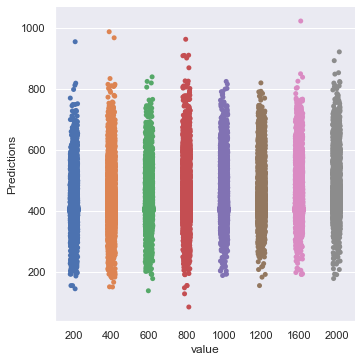

In [228]:
# Graph actual v. predicted values for neural network model
sns.catplot(x='value',y='Predictions', data=nn_regressor_actual_preds)
plt.savefig('catplot.png');

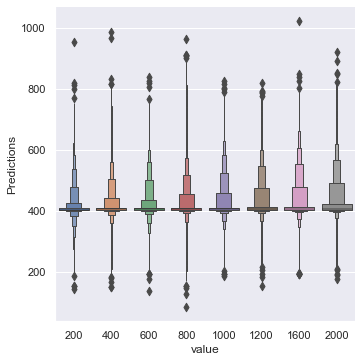

In [229]:
sns.catplot(x='value', y='Predictions', data=nn_regressor_actual_preds, kind="boxen")
plt.savefig('catplot_boxen.png');

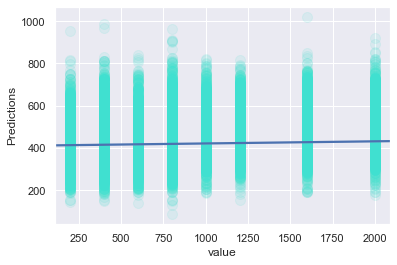

In [304]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=nn_regressor_actual_preds, fit_reg=True, scatter_kws={'color': 'turquoise', 'alpha': 0.1, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_bothrounds.png');

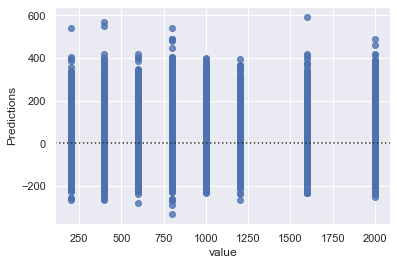

In [230]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=nn_regressor_actual_preds)
plt.savefig('redidplot.png');

### Neural Network on Separated Rounds

In [194]:
# Create train-test splits for each round
nn_X1_train, nn_X1_test, nn_y1_train, nn_y1_test = train_test_split(X1, y1, test_size= 0.25, random_state=54)
nn_X2_train, nn_X2_test, nn_y2_train, nn_y2_test = train_test_split(X2, y2, test_size= 0.25, random_state=54)

In [195]:
# Instantiate the vectorizer with stop words, bigrams, and max features of 1000
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 2), max_features=1000)

# Fit the vectorizer on X1_train and transform it
nn_X1_train_vectorized = tfidf.fit_transform(nn_X1_train).todense()

# Fit the vectorizer on X2_train and transform it
nn_X2_train_vectorized = tfidf.fit_transform(nn_X2_train).todense()

In [ ]:
# Run a 3 fold cross validation on Round 1 data
nn_round1_cv = cross_val_score(keras_wrapper, nn_X1_train_vectorized, nn_y1_train, cv=3, scoring=mape_score)

Epoch 1/30
465/465 [==============================] - 3s 5ms/step - loss: 69.8260 - mape: 69.8260
Epoch 2/30
465/465 [==============================] - 2s 5ms/step - loss: 49.8677 - mape: 49.8677
Epoch 3/30
465/465 [==============================] - 2s 4ms/step - loss: 49.5847 - mape: 49.5847
Epoch 4/30
465/465 [==============================] - 3s 5ms/step - loss: 49.4267 - mape: 49.4267
Epoch 5/30
465/465 [==============================] - 3s 7ms/step - loss: 49.3212 - mape: 49.3212
Epoch 6/30
465/465 [==============================] - 3s 6ms/step - loss: 49.2294 - mape: 49.2294
Epoch 7/30
465/465 [==============================] - 3s 7ms/step - loss: 49.1361 - mape: 49.1361
Epoch 8/30
465/465 [==============================] - 4s 8ms/step - loss: 49.0360 - mape: 49.0360
Epoch 9/30
465/465 [==============================] - 4s 9ms/step - loss: 48.9190 - mape: 48.9190: 0s - loss: 48.8586 - map
Epoch 10/30
465/465 [==============================] - 3s 6ms/step - loss: 48.7923 - mape: 4

In [204]:
# Round 1 mape scores
nn_round1_cv

array([-50.20011907, -49.99654066, -49.87118912])

In [205]:
print("Round 1 Neural Network:", (nn_round1_cv.mean()))

Round 1 Neural Network: -50.02261628426948


In [206]:
# Vectorize X1_test
nn_X1_test_vectorized = tfidf.transform(nn_X1_test).todense()

In [207]:
# Make predictions using Round 1 testing set
print("Evaluate model on test data")
nn_round1_test_results = model2.evaluate(nn_X1_test_vectorized, nn_y1_test, batch_size=128)

Evaluate model on test data
364/364 [==============================] - 1s 4ms/step - loss: 50.8161 - mape: 50.8161


In [208]:
print(nn_round1_test_results)

[50.81612014770508, 50.81612014770508]


In [234]:
y1_pred = model2.predict(nn_X1_test_vectorized)

In [235]:
# Mape for Round 1 test data
nn1_mape = mean_absolute_percentage_error(nn_y1_test, y1_pred)
nn1_mape

50.81611784852606

In [ ]:
# Change y_pred into a pandas df
nn1_regressor_pred = pd.DataFrame(y1_pred, columns = ['Predictions'])

In [238]:
# Create a df with actual and predicted Round 1 y_test values
nn1_regressor_actual_preds = pd.concat([nn_y1_test.reset_index(drop=True), nn1_regressor_pred.reset_index(drop=True)], axis=1)
nn1_regressor_actual_preds

,value,Predictions
0,200,403.615753
1,200,401.925934
2,400,406.018768
3,400,388.426422
4,1000,487.708252
...,...,...
46475,200,562.849487
46476,200,447.488617
46477,1000,399.063324
46478,1000,491.439270


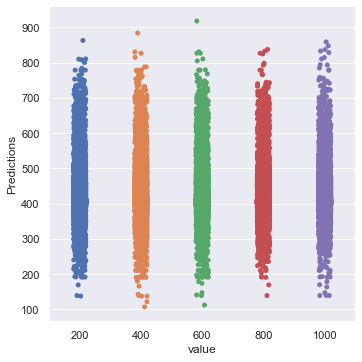

In [239]:
# Graph actual v. predicted values for Round 1 neural network model
sns.catplot(x='value',y='Predictions', data=nn1_regressor_actual_preds)
plt.savefig('catplot.png');

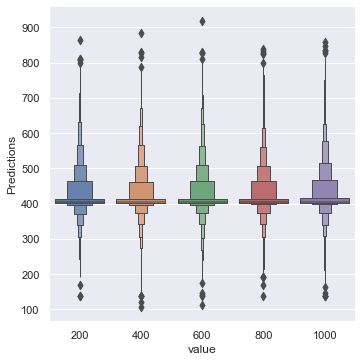

In [240]:
sns.catplot(x='value', y='Predictions', data=nn1_regressor_actual_preds, kind="boxen")
plt.savefig('catplot_boxen.png');

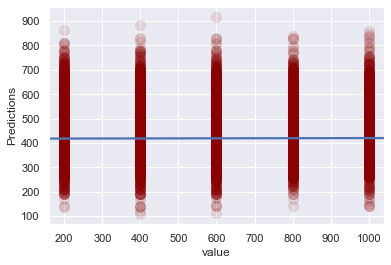

In [242]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=nn1_regressor_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_bothrounds.png');

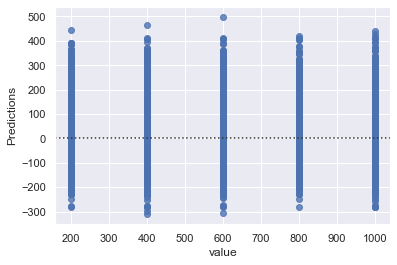

In [241]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=nn1_regressor_actual_preds)
plt.savefig('redidplot.png');

In [ ]:
# Run a 3 fold cross validation on Round 2 data
nn_round2_cv = cross_val_score(keras_wrapper, nn_X2_train_vectorized, nn_y2_train, cv=3, scoring=mape_score)

Epoch 1/30
445/445 [==============================] - 2s 4ms/step - loss: 73.7272 - mape: 73.7272
Epoch 2/30
445/445 [==============================] - 2s 5ms/step - loss: 49.7542 - mape: 49.7542
Epoch 3/30
445/445 [==============================] - 2s 6ms/step - loss: 49.4692 - mape: 49.4692
Epoch 4/30
445/445 [==============================] - 2s 4ms/step - loss: 49.2921 - mape: 49.2921
Epoch 5/30
445/445 [==============================] - 2s 5ms/step - loss: 49.1603 - mape: 49.1603: 0s - los
Epoch 6/30
445/445 [==============================] - 2s 5ms/step - loss: 49.0282 - mape: 49.0282
Epoch 7/30
445/445 [==============================] - 2s 4ms/step - loss: 48.9187 - mape: 48.9187
Epoch 8/30
445/445 [==============================] - 2s 6ms/step - loss: 48.8129 - mape: 48.8129
Epoch 9/30
445/445 [==============================] - 2s 5ms/step - loss: 48.7156 - mape: 48.7156
Epoch 10/30
445/445 [==============================] - 2s 5ms/step - loss: 48.6233 - mape: 48.6233
Epoch 11/

In [210]:
# Round 2 mape scores
nn_round2_cv

array([-50.21433092, -49.98945361, -50.10272866])

In [211]:
print("Round 2 Neural Network:", (nn_round2_cv.mean()))

Round 2 Neural Network: -50.10217106497623


In [212]:
# Vectorize X2_test
nn_X2_test_vectorized = tfidf.transform(nn_X2_test).todense()

In [213]:
# Make predictions using Round 2 testing set

print("Evaluate model on test data")
nn_round2_test_results = model2.evaluate(nn_X2_test_vectorized, nn_y2_test, batch_size=128)

Evaluate model on test data
348/348 [==============================] - 1s 3ms/step - loss: 53.1458 - mape: 53.1458: 


In [214]:
print("Round 2 Test Results: ",nn_round2_test_results)

Round 2 Test Results:  [53.14578628540039, 53.14578628540039]


In [243]:
y2_pred = model2.predict(nn_X2_test_vectorized)

In [244]:
# Mape for Round 2 test data
nn2_mape = mean_absolute_percentage_error(nn_y2_test, y2_pred)
nn2_mape

53.14581452141016

In [246]:
#change y_pred into a pandas df
nn2_regressor_pred = pd.DataFrame(y2_pred, columns = ['Predictions'])
nn2_regressor_pred

,Predictions
0,405.427063
1,373.215118
2,401.714569
3,403.572571
4,406.392975
...,...
44457,380.833221
44458,408.736237
44459,481.332825
44460,406.550385


In [247]:
# Create a df with actual and predicted Round 2 y_test values
nn2_regressor_actual_preds = pd.concat([nn_y2_test.reset_index(drop=True), nn2_regressor_pred.reset_index(drop=True)], axis=1)
nn2_regressor_actual_preds

,value,Predictions
0,800,405.427063
1,400,373.215118
2,1600,401.714569
3,2000,403.572571
4,1600,406.392975
...,...,...
44457,1200,380.833221
44458,1200,408.736237
44459,800,481.332825
44460,400,406.550385


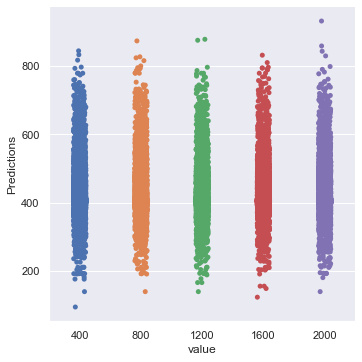

In [248]:
# Graph actual v. predicted values for Round 2 neural network model
sns.catplot(x='value',y='Predictions', data=nn2_regressor_actual_preds)
plt.savefig('catplot.png');

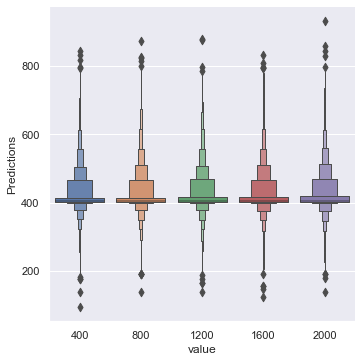

In [249]:
sns.catplot(x='value', y='Predictions', data=nn2_regressor_actual_preds, kind="boxen")
plt.savefig('catplot_boxen.png');

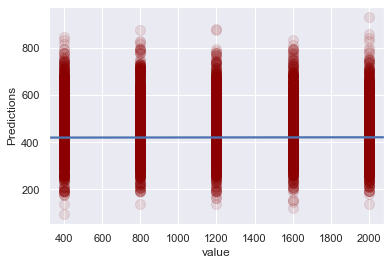

In [251]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=nn2_regressor_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.1, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_bothrounds.png');

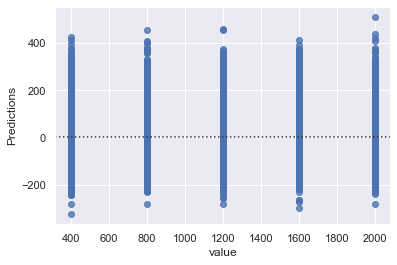

In [250]:
# Plot residuals
sns.residplot(x='value',y='Predictions', data=nn2_regressor_actual_preds)
plt.savefig('redidplot.png');

## Doc2Vec

Use Doc2Vec to see if taking documents (the words in questions and answers) as a single unit would improve model performance more than examining words individually (or as bigrams/trigrams). Shoutout to William Morgan, https://medium.com/@morga046/multi-class-text-classification-with-doc2vec-and-t-sne-a-full-tutorial-55eb24fc40d3 and Radim Řehůřek, https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html

In [171]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes,q_and_a
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-,river mentioned most often in the bible the jo...
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-,scottish word for lake loch
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-,american river only mile shorter than the miss...
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-,world largest lake nearly time a big a superio...
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-,marconi wonderful wireless the radio
...,...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-,in a moveable feast gertrude stein is quoted a...
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-,this hefty noisemaker from whitechapel foundry...
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-,around year ago the first foundry in mesopotam...
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-,several different foundry worked for month to ...


In [43]:
# Tokenize 'q_and_a' category
tokenized = df['q_and_a'].apply(word_tokenize)

In [46]:
# Tokenize the 'q_and_a' categories for each round
round1_tokenized = round1['q_and_a'].apply(word_tokenize)
round2_tokenized = round2['q_and_a'].apply(word_tokenize)

In [50]:
# Create train-test splits
train, test = train_test_split(df, test_size=.30, random_state=54)
round1_train, round1_test = train_test_split(round1, test_size=.30, random_state=54)
round2_train, round2_test = train_test_split(round2, test_size=.30, random_state=54)

In [53]:
#Tag train set
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(train.answer)]
#Tag test set
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(test.answer)]

In [54]:
#Tag Round 1 train set
round1_tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(round1_train.q_and_a)]
#Tag test set
round1_tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(round1_test.q_and_a)]

In [55]:
#Tag Round 2 train set
round2_tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(round2_train.q_and_a)]
#Tag test set
round2_tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(round2_test.q_and_a)]

In [ ]:
model = Doc2Vec(vector_size=100,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8,
                epochs=40)
model.build_vocab(tagged_tr)

In [ ]:
round2_model = Doc2Vec(vector_size=100,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8,
                epochs=40)
round2_model.build_vocab(round2_tagged_tr)

In [ ]:
round3_model = Doc2Vec(vector_size=100,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8,
                epochs=40)
round3_model.build_vocab(round2_tagged_tr)

In [59]:
# Extract training vectors:
X_train = np.array([model.dv[str(i)] for i in range(len(tagged_tr))])
y_train = train['value']

In [60]:
# Extract Round 1 training vectors:
round1_X_train = np.array([round1_model.dv[str(i)] for i in range(len(round1_tagged_tr))])
round1_y_train = round1_train['value']

In [61]:
# Extract Round 2 training vectors:
round2_X_train = np.array([round2_model.dv[str(i)] for i in range(len(round2_tagged_tr))])
round2_y_train = round2_train['value']

In [62]:
#Use ‘infer_vector’ to generate vectors for the test set:
X_test = np.array([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test['value']

In [63]:
#Use ‘infer_vector’ to generate vectors for the Round 1 test set:
round1_X_test = np.array([round1_model.infer_vector(round1_tagged_test[i][0]) for i in range(len(round1_tagged_test))])
round1_y_test = round1_test['value']

In [64]:
#Use ‘infer_vector’ to generate vectors for the Round 2 test set:
round2_X_test = np.array([round2_model.infer_vector(round2_tagged_test[i][0]) for i in range(len(round2_tagged_test))])
round2_y_test = round2_test['value']

In [281]:
#Cross validate with linear SVR 
linear_SVR_regressor = LinearSVR(verbose = 10)
ln_SVR_cv = cross_val_score(linear_SVR_regressor, X_train, y_train, cv=5, scoring=mape_score)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [282]:
ln_SVR_cv

array([-72.21028793, -71.70197865, -72.44775201, -72.06923636,
       -71.64176174])

In [283]:
ln_SVR_cv.mean()

-72.01420333680235

In [ ]:
# Run linear SVR on separate rounds

In [300]:
round1_ln_SVR_cv = cross_val_score(linear_SVR_regressor, round1_X_train, round1_y_train, cv=5, scoring=mape_score)
round1_ln_SVR_cv

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

array([-65.68444417, -64.28727842, -64.9594073 , -64.47206281,
       -64.0876984 ])

In [302]:
round1_ln_SVR_cv.mean()

-64.69817822091383

In [301]:
round2_ln_SVR_cv = cross_val_score(linear_SVR_regressor, round2_X_train, round2_y_train, cv=5, scoring=mape_score)
round2_ln_SVR_cv

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

array([-66.10488178, -67.12700433, -66.49243356, -65.45416719,
       -66.26702115])

In [303]:
round2_ln_SVR_cv.mean()

-66.28910159944219